# Gillespie simulation of the chemical master equation

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import itertools
import re
import pickle
import glob

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy as sp
import numba

# Import libraries to parallelize processes
from joblib import Parallel, delayed
import multiprocessing

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns
# Increase DPI of displayed figures
%config InlineBackend.figure_format = 'retina'

# Import the project utils
import ccutils

tmpdir = '../../tmp/'
figdir = '../../fig/gillespie_simulation/'
datadir = '../../data/csv_gillespie/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{th}[1]{\text{th}}$

### Credit

The implementation of the Gillespie algorithm in this notebook is entirely based on [Justin Bois'](http://bois.caltech.edu) tutorial that can be found [here](http://be150.caltech.edu/2017/handouts/gillespie_simulation.html).

## Gillespie simulation of the chemical master equation

As an alternative method to sample the joint mRNA protein distribution $P(m, p)$ we can use the Gillespie algorithm. This is a great alternative since the algorithm is widely used in many fields and therefore its intuitive implementation is familiar to a broad audience. Having said that, as we will show in this notebook, the algorithm can be computationally inefficient for large sample spaces since the number of computations that one has to generate to reliably sample the distribution usually grows as $N^2$ where $N$ is the sample space size.

### Propensities

The basis of the algorithm is the computation of the transition probabilities between states, In the context of the algorithm we need to compute the so-called *propensities*. These propensities dictate how likely it is for each of the possible reactions to take place. Some of the propensities have a fix value and others are updated as the chemical species change their numbers. For example, the propensity of producing an mRNA can be considered fix for a single promoter since it is just given by the mRNA production rate $r_m$, while the propensity for an mRNA to be degraded changes as the number of mRNA changes since it is given by the product of the mRNA degradation rate $\gm$ times the number of mRNAs $m$.

In order to stochastically choose which reaction $i$ will take place in the next small time window $\Delta t$ we then compute
$$
P_i = {a_i \over \sum_j a_j},
$$
where $a_i$ is the propensity of reaction $i$. In other words, the propensities are normalized by summing over all propensities of each of the possible reactions to assign a probability for each of the reactions of taking place.

### Reaction time

For a particular reaction $i$ we need to determine how long it took for this state change to take place. For a given reaction $i$ the probability that it took place in time $t$ has an exponential distribution of the form
$$
P(t \mid a_i) = a_i e^{- a_i t},
$$
since each of them are assumed to be Poission processes. That means that the probability that reaction $i$ **didn't take place** during the time window $\Delta t$ as the form
$$
P(t > \Delta t \mid a_i) = \int_{\Delta t}^\infty dt P(t \mid a_i)
= e^{- a_i \Delta t}.
$$

If we have a total of $n$ possible reactions each with propensities $a_1, a_2, \ldots, a_n$, the probability that none of them take place during the time window $\Delta t$ is given by
$$
P(t_1 > \Delta t, t_2 > \Delta t, \ldots, t_n > \Delta t) =
P(t_1 > \Delta t) \cdot P(t_2 > \Delta t) \cdots P(t_n > \Delta t),
$$
since each of these reactions are independent. Substituting these probabilities gives
$$
P(t_1 > \Delta t, t_2 > \Delta t, \ldots, t_n > \Delta t) =
\prod_i e^{-a_i \Delta t} = \exp\left[ - \Delta t \sum_i a_i \right].
$$
This is the equivalent to having a single Poisson process with rate $a = \sum_i a_i$ not arriving before time $\Delta t$. That means that the probability that any of the reactions **does arrive** during time $\Delta t$ is given by an exponential distribution with mean $\ee{t} = \left( \sum_i a_i \right)^{-1}$.

## The recipe for Gillespie's algorithm

This result leaves us with a simple recipe to implement Gillespie's algorithm:
1. Choose initial conditions for the value of the chemical species.
2. Calculate the propensity of each of the possible state changes.
3. Compute the time that it took for a reaction to take place by sampling out of an exponential distribution with mean $\ee{t} = \left( \sum_i a_i \right){-1}$.
4. Choose which reaction takes place by sampling out of the discrete distribution wit probabilities $P_i = a_i / \sum_j a_j$.
5. Update the time step by the chosen $\Delta t$.
6. Update the states according to the reaction chosed in step 4.
7. If $t$ is less than predetermined stopping time, go to step 2 and repeat.

## Test: Two-state promoter mRNA level

To test our implementation of the Gillespie algorithm we'll start with a two-state promoter producing mRNA at rate $r_m$, degrading it at rate $\gm$ and transitioning between states with rates $\kpon$ and $\kpoff$. The first thing we do is enconde the updates to the element counts.

In [3]:
# Column 0 is change in active promoter
# Column 1 is change in inactive promoter
# Column 2 is change in mRNA counts
simple_update = np.array([[1, -1, 0],  # Transition from inactive to active
                          [-1, 1, 0],  # Transition from active to inactive
                          [0, 0, 1],   # Production of mRNA
                          [0, 0, -1]], # Degradation of mRNA
                        dtype=np.int)

Now we define a function that computes the propensity of each of these reactions. Notice that we will keep the state of the promoter as a chemical species that we track. Also notice that the propensity of the mRNA production is a product of the mRNA transcription rate $r_m$ times the counts of the active promoter state. Since this count can only be either 0 or 1, this indicates that an mRNA can only be produced if the promoter is in the active state. The same is true for the propensities of the state transition since the promoter can only transition from the active state $A$ to the inactive state $I$ if it is already in the active state.

In [8]:
def simple_propensity(population, kpon, kpoff, rm, gm):
    """
    Returns an array of the propensities given a set of parameters for a 
    two-sate promoter at the mRNA level
    
    Parameters
    ----------
    population : array-like.
        State of the molecule count for each of the species involved in the
        reaction. [active_promoter, inactive_promoter, mRNA]
    kpon, kpoff : float.
        Rates of transition between active and inactive promoter.
    rm, gm : float.
        Rate of mRNA production and degradation respectively.
        
    Returns
    -------
    propensities : array-like
        Propensities for each of the reactions.
    """
    # Unpack population
    a_prom, i_prom, m = population

    return np.array(
        [
            i_prom * kpon,  # Transition from inactive to active
            a_prom * kpoff,  # Transition from active to inactive
            a_prom * rm,  # Production of mRNA
            gm * m,
        ]  # Degradation m RNA
    )

### Making a draw

The Gillespie algorithm relies on generating (pseudo-)random numbers in order to decide which reaction takes place and how long it takes for such reaction to happen. Generating the time it takes is very simple using `np.random.exponential()`. For picking the reaction we could in principle use scipy's random variable sampler, but as shown in the tutorial listed at the beginning of this notebook, this is a very slow process. Therefore we will code our own discrete sampler.

In [9]:
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number between zero and 1
    q = np.random.rand()

    # Find index of selected state
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

With this function we can choose at random one of the reactions to happen depending on the propensity values. Now we are ready to code a function that performs a single draw of our Gillespie algorithm, meaning sampling the time interval and the reaction.

In [10]:
# Function to draw time interval and choice of reaction
def gillespie_draw(propensity_func, population, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    props = propensity_func(population, *args)

    # Sum of propensities
    props_sum = props.sum()

    # Compute time
    time = np.random.exponential(1.0 / props_sum)

    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum

    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)

    return rxn, time

## Stochastic simulation

We now have everthing ready to code up our stochastic simulation. Now we just need to define a function that uses our propensity functions, our sample draw function and updates the particle state keeping track of thte particle count.

In [12]:
def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1  # Initialize time index
    i = 0  # Initialize reaction count index
    t = time_points[0]  # Initialize time
    population = population_0.copy()  # Initialize molecule count
    pop_out[0, :] = population  # Update array of molecule count
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, population, args)

            # Update the population
            population_previous = population.copy()
            population += update[event, :]

            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)

        # Update the population
        pop_out[i_time : min(i, len(time_points))] = population_previous

        # Increment index
        i_time = i

    return pop_out

Let's now define the parameters for the two-state promoter

In [13]:
# Import parameters
param = ccutils.model.load_constants()

kp_on = param['kp_on']
kp_off = param['kp_off']
rm = param['rm']
gm = param['gm']

Now we have everything ready to run the simulation!

Let's pack all the necessary inputs and run 100 individual trajectories.

In [15]:
# Specify parameters for calculation
args = np.array([kp_on, kp_off, rm, gm])
time_points = np.linspace(0, 6000, 1000)
population_0 = np.array([1, 0, 0], dtype=int)
n_simulations = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty(
    (n_simulations, len(time_points), len(population_0)), dtype=int
)

# Run the calculations
for i in range(n_simulations):
    pops[i, :, :] = gillespie_ssa(
        simple_propensity,
        simple_update,
        population_0,
        time_points,
        args=args
    )

Having run the simulatinos let's take a look at the trajectories.

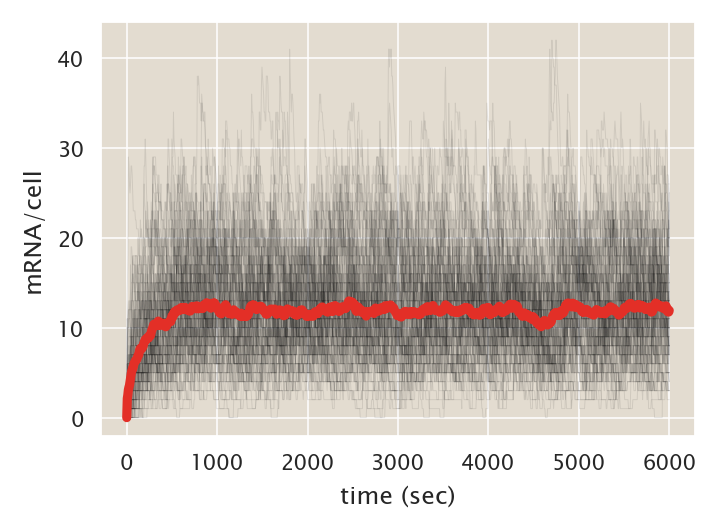

In [17]:
# Initialize plot
fig = plt.figure()

# Loop through trajectories
for i in range(n_simulations):
    plt.plot(time_points, pops[i,:,2], '-', lw=0.3, alpha=0.1,
             color='k')
    
# Plot mean mRNA
plt.plot(time_points, pops[:, :, 2].mean(axis=0), '-', lw=3,
         color=sns.color_palette('Reds_r', n_colors=2)[0])

plt.xlabel('time (sec)')
plt.ylabel('mRNA/cell');

These trajectories look reasonable. Let's try to speed up things using `numba`.

## Speeding up things with `Numba`

To run these stochastic simulations with a speed bust we'll use Python's incredibly powerful library `Numba`. This package under the hood does just-in-time (JIT) compilation of Python code, which as shown in the tutorial at the beginning of this notebook, can add up to a significant speed boost. All we have to do is decorate our functions with the command

`@numba.jit(nopython=True)`,

simple as that.

For example let's first optimize the propensity function.

In [19]:
@numba.jit(nopython=True)
def simple_propensity_numba(population, kpon, kpoff, rm, gm):
    '''
    Returns an array of the propensities given a set of parameters for a 
    two-sate promoter at the mRNA level
    
    Parameters
    ----------
    population : array-like.
        State of the molecule count for each of the species involved in the
        reaction. [active_promoter, inactive_promoter, mRNA]
    kpon, kpoff : float.
        Rates of transition between active and inactive promoter.
    rm, gm : float.
        Rate of mRNA production and degradation respectively.
        
    Returns
    -------
    propensities : array-like
        Propensities for each of the reactions.
    '''
    # Unpack population
    a_prom, i_prom, m = population
    
    return np.array([i_prom * kpon,  # Transition from inactive to active
                     a_prom * kpoff,  # Transition from active to inactive
                     a_prom * rm,  # Production of mRNA
                     gm * m]  # Degradation m RNA
                   )

# Check speeds
# Check speeds
print('Old propensity function:')
%timeit simple_propensity(population_0, *args)

print('\nNumba\'d propensity function:')
%timeit simple_propensity_numba(population_0, *args)

Old propensity function:
11.1 µs ± 262 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Numba'd propensity function:
The slowest run took 8.23 times longer than the fastest. This could mean that an intermediate result is being cached.
5.29 µs ± 6.08 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Not a bad improvement. Following up the tutorial let's generate a `jit` function to perform the sum to normalize the propensities.

In [20]:
@numba.jit(nopython=True)
def sum_numba(ar):
    return ar.sum()

# Make dummy array for testing
ar = np.array([0.3, 0.4, 0.3, 0.2, 0.15])

print('\nNumPy sum:')
%timeit ar.sum()

print('\nNumba sum:')
%timeit sum_numba(ar)


NumPy sum:
2.21 µs ± 44.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Numba sum:
293 ns ± 3.32 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Not bad at all as well. Finally, following the tutorial we will speed up the sampling of the discrete distribution in two different ways:
- First we do not need to necessaryly sample from a normalized distribution since the division to normalize propensities takes a long time. So we will do this from an unnormalized distribution.
- Second we will use `numba` again to accelerate the `while` loop.

In [21]:
@numba.jit(nopython=True)
def sample_discrete_numba(probs, probs_sum):
    q = np.random.rand() * probs_sum

    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

# Make dummy unnormalized probs
probs = np.array([0.1, 0.3, 0.4, 0.05, 0.15, 0.6])
probs_sum = sum_numba(probs)

print('Result from hand-coded method:')
%timeit sample_discrete(probs)

print("\nResults from numba'd version:")
%timeit sample_discrete_numba(probs, probs_sum)

Result from hand-coded method:
1.59 µs ± 26.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

Results from numba'd version:
329 ns ± 6.43 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Another pretty good improvement!
Finally let's code a new way to draw the gillespie sample. We will feed our fast propensity function as an argument for this function.

In [22]:
def gillespie_draw_fast(propensity_func, population, args):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = propensity_func(population, *args)
    
    # Sum of propensities
    props_sum = sum_numba(props)
    
    # Compute time
    time = np.random.exponential(1 / props_sum)

    # Draw reaction given propensities
    rxn = sample_discrete_numba(props, props_sum)
    
    return rxn, time

print('Old Gillespie draw:')
%timeit gillespie_draw(simple_propensity, population_0, args)

print('\nFast Gillespie draw:')
%timeit gillespie_draw_fast(simple_propensity_numba, population_0, args)

Old Gillespie draw:
25.1 µs ± 719 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Fast Gillespie draw:
6.52 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


With all these improvements let's now rewrite the stochastic simulation algorithm function using our `numba`'d functions. All we will adjust here is the way that the random draws are done.

In [24]:
def gillespie_ssa_fast(
    propensity_func, update, population_0, time_points, args=()
):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func. 
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0, :] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw_fast(
                propensity_func,
                population,
                args
            )

            # Update the population
            population_previous = population.copy()
            population += update[event, :]

            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)

        # Update the population
        pop_out[i_time : min(i, len(time_points))] = population_previous

        # Increment index
        i_time = i

    return pop_out

Let's compare both methods now to see how much our simulation was improved.

In [25]:
print('Gillespie SSA:')
%timeit gillespie_ssa(simple_propensity, simple_update, \
                      population_0, time_points, args)

print('\nFast numba Gillespie SSA:')
%timeit gillespie_ssa_fast(simple_propensity_numba, simple_update,\
                           population_0, time_points, args)

Gillespie SSA:
40.2 ms ± 827 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Fast numba Gillespie SSA:
17.3 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Overall we got a pretty decent improvement. Our simulations will run at least twice as fast then.

Let's reproduce the previous simulation with this fast algorithm. This time we will run twice as many trajectories since our algorithm is now twice as fast.

In [27]:
# Specify parameters for calculation
args = np.array([kp_on, kp_off, rm, gm])
time_points = np.linspace(0, 6000, 1000)
population_0 = np.array([1, 0, 0], dtype=int)
n_simulations = 200

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty(
    (n_simulations, len(time_points), len(population_0)), dtype=int
)

# Run the calculations
for i in range(n_simulations):
    pops[i, :, :] = gillespie_ssa_fast(
        simple_propensity_numba,
        simple_update,
        population_0,
        time_points,
        args=args,
    )

Now let's look at the results.

Text(0, 0.5, 'mRNA/cell')

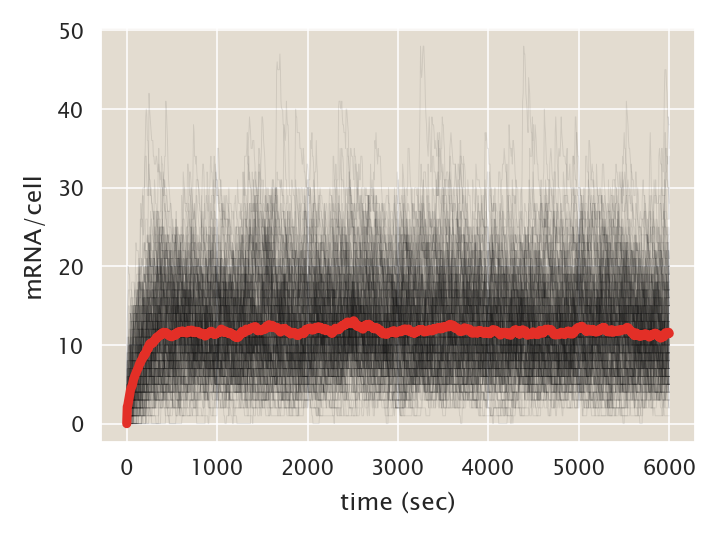

In [29]:
# Initialize plot
fig = plt.figure()

# Loop through trajectories
for i in range(n_simulations):
    plt.plot(time_points, pops[i, :, 2], "-", lw=0.3, alpha=0.1, color="k")

# Plot mean mRNA
plt.plot(
    time_points,
    pops[:, :, 2].mean(axis=0),
    "-",
    lw=3,
    color=sns.color_palette("Reds_r", n_colors=2)[0],
)

plt.xlabel("time (sec)")
plt.ylabel("mRNA/cell")

Excellent. Everything seems to be working as expected. Now we are ready to take into account variability across the cell cycle.

### Running simulation over several cell cycles

In order to be able to compare these results with our MaxEnt approach we need to run these simulations over several cell cycles. What this implies is that we need to account for the gene copy number variability as well as the binomial partitioning of the mRNA after cell division. This is fairly simple to do, all we need to keep track of is when cells have one vs two copies of the promoter and when cells division happens.

In [31]:
def gillespie_cell_cycle(
    n_simulations,
    n_cycles,
    t_single,
    t_double,
    args_single,
    args_double,
    propensity_func,
    update,
    population_0,
    binom_idx=[2],
):
    """
    Parameters
    ----------
    n_simulations: int.
        Number of single trajectories to simulate.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    t_single : float.
        Time that cells spend with a single promoter copy
    t_double : float.
        Time that cells spend with a two promoter copies.
    args_single : tuple
        The set of parameters to be passed to propensity_func for cells with
        a single copy of the promoter.
    args_double : tuple
        The set of parameters to be passed to propensity_func for cells with
        two copies of the promoter.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (n_simulations x num_chemical_species)
        Array of initial populations of all chemical species.
    binom_idx : list, shape = population_0.shape
        Index that points at which values of the population will undergo a
        binomial partitioning to simulate each cell division.

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """
    # Define cell cycle length
    len_single = len(t_single)
    len_double = len(t_double)
    len_cycle = len_single + len_double
    # Initialize output array
    pops = np.empty(
        (n_simulations, n_cycles * len_cycle, population_0.shape[1]), 
        dtype=int
    )

    # Set initial population for each trajectory
    pop_init = population_0.copy()

    # Loop through cell cycles
    for cyc in range(n_cycles):
        # Define positions to save cell cycle
        single_pos = [cyc * len_cycle, cyc * (len_cycle) + len_single]
        double_pos = [cyc * len_cycle + len_single, (cyc + 1) * len_cycle]

        # Simulate single-promoter strains
        for i in range(n_simulations):
            pops[i, single_pos[0] : single_pos[1], :] = gillespie_ssa_fast(
                propensity_func,
                update,
                pop_init[i, :],
                t_single,
                args=args_single,
            )
        # Extract last time point as initial condition for next stage
        pop_init = pops[:, single_pos[1] - 1, :]

        # Simulate double-promoter strains
        for i in range(n_simulations):
            pops[i, double_pos[0] : double_pos[1], :] = gillespie_ssa_fast(
                propensity_func,
                update,
                pop_init[i, :],
                t_double,
                args=args_double,
            )

        # Extract last time point as inital condition for next stage
        pop_init = pops[:, double_pos[1] - 1, :]

        # Simulate cell division as a binomial partitioning of molecules
        for b in binom_idx:
            pop_init[:, b] = np.random.binomial(pop_init[:, b], 0.5)

    return pops

Having coded this function let's test it for several cell cycles. We will use the same conditions that we used with the MaxEnt approach, meaning a doubling time of 100 minutes where cells spend 60% of the time with one promoter and the rest with two promoters. The difference will be that the transcription rate $r_m$ will be doubled.

In [33]:
# Specify parameters for calculation
args_single = np.array([kp_on, kp_off, rm, gm])
args_double = np.array([kp_on, kp_off, 2 * rm, gm])

# Define doubling time
doubling_time = 100
# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
single = 60 * t_single_frac * doubling_time  # sec
double = 60 * (1 - t_single_frac) * doubling_time  # sec
# Specify time points for each cell cycle
t_single = np.linspace(0, single, 1000)
t_double = np.linspace(0, double, 1000)
# Define cell cycle length
len_single = len(t_single)
len_double = len(t_double)
len_cycle = len_single + len_double

# Define number of simulations
n_simulations = 100
# Initialize population for
population_0 = np.array([1, 0, 0], dtype=int)
population_0 = np.tile(population_0, (n_simulations, 1))

# Define number of cell cycles
n_cycles = 4

# Define entire time
time_points = np.array([0])
# Define copy number index
copy_idx = list()
# Define cycle index
cycle_idx = list()
for cyc in range(n_cycles):
    # Single-promoter time values
    time_points = np.append(
        time_points, t_single + time_points[-1] + np.diff(t_single)[0]
    )
    # Two-promoter time values
    time_points = np.append(
        time_points, t_double + time_points[-1] + np.diff(t_double)[0]
    )

    # Append index for copy number
    copy_idx = copy_idx + ["single"] * len_single
    copy_idx = copy_idx + ["double"] * len_double

    # Append index for cell cycle number
    cycle_idx = cycle_idx + [cyc] * len_cycle

# Remove first time point that was a place holder
time_points = time_points[1:]

pops = gillespie_cell_cycle(
    n_simulations,
    n_cycles,
    t_single,
    t_double,
    args_single,
    args_double,
    simple_propensity_numba,
    simple_update,
    population_0,
)

Let's now arrange this messy data set into a tidy dataframe that will be much easier to handle.

In [35]:
# Extract mRNA counts
pops_mRNA = pops[:, :, 2]

# Set column titles for data frame
names = ["t" + str(i) for i in range(n_simulations)]

# Convert array into data frame
df_sim_mRNA = pd.DataFrame(pops_mRNA.T, columns=names)
# Add time
df_sim_mRNA["time"] = time_points
# Add cycle number
df_sim_mRNA["cycle"] = cycle_idx
# Add promoter state
df_sim_mRNA["state"] = copy_idx

# Use pandas melt function to convert it into long format
df_sim_mRNA = df_sim_mRNA.melt(
    value_vars=names,
    id_vars=["time", "cycle", "state"],
    value_name="mRNA",
    var_name="sim_num",
)
# Extract promoter state
pops_prom = pops[:, :, 0]
# Generate dataframe to extract melted column
df = pd.DataFrame(pops_prom.T, columns=names).melt(value_vars=names)
# Add promoter state
df_sim_mRNA["prom_state"] = df.value

df_sim_mRNA.head()

,time,cycle,state,sim_num,mRNA,prom_state
0,3.603604,0,single,t0,0,1
1,7.207207,0,single,t0,2,0
2,10.810811,0,single,t0,1,0
3,14.414414,0,single,t0,1,0
4,18.018018,0,single,t0,5,0


Excellent. Now that we have the simulations let's take a look at the time trajectories of the mRNA counts.

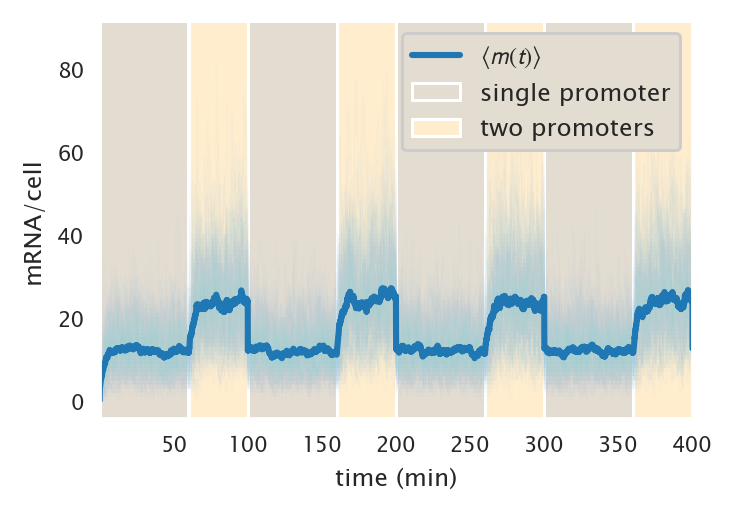

In [39]:
# Group data by simulation number
df_group = df_sim_mRNA.groupby("sim_num")

# Initialize plot
fig = plt.figure()

# Define colors
colors = sns.color_palette("Paired", n_colors=2)
# Loop through each simulation
for group, data in df_group:
    plt.plot(
        data.time / 60,
        data.mRNA,
        "-",
        lw=0.3,
        alpha=0.05,
        color=colors[0],
        label="",
    )

# Compute mean mRNA
mean_mRNA = [data.mRNA.mean() for group, data in df_sim_mRNA.groupby("time")]
# # Plot mean mRNA
plt.plot(
    time_points / 60,
    mean_mRNA,
    "-",
    lw=2,
    color=colors[1],
    label=r"$\left\langle m(t) \right\rangle$",
)

# Group data frame by cell cycle
df_group = df_sim_mRNA.groupby("cycle")
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_sim_mRNA["cycle"].max():
        label_s = "single promoter"
        label_d = "two promoters"
    else:
        label_s = ""
        label_d = ""
    # Find index for one-promoter state
    idx = np.where(data.state == "single")[0]
    # Indicate states with two promoters
    plt.axvspan(
        data.iloc[idx.min()]["time"] / 60,
        data.iloc[idx.max()]["time"] / 60,
        facecolor="#e3dcd1",
        label=label_s,
    )

    # Find index for two-promoter state
    idx = np.where(data.state == "double")[0]
    # Indicate states with two promoters
    plt.axvspan(
        data.iloc[idx.min()]["time"] / 60,
        data.iloc[idx.max()]["time"] / 60,
        facecolor="#ffedce",
        label=label_d,
    )

# Set limits
plt.xlim(df_sim_mRNA["time"].min() / 60, df_sim_mRNA["time"].max() / 60)
# Label plot
plt.xlabel("time (min)")
plt.ylabel("mRNA/cell")
plt.legend(loc="upper right")

# Save figure
plt.tight_layout()
plt.savefig(figdir + "mRNA_two_state_gillespie.pdf")

## Running simulations on several cores

The last speed boost we'll implement for our simulations will be to take advantage of multiple cores to parallelize the simulations. For this, again following the fantastic tutorial, we will use the `multiprocessing` package. This requires us to write a function that takes a single argument as an input.

In [41]:
def gillespie_fn(args):
    return gillespie_cell_cycle(*args)


def gillespie_parallel(
    fn,
    n_simulations,
    n_cycles,
    t_single,
    t_double,
    args_single,
    args_double,
    propensity_func,
    update,
    population_0,
    binom_idx=[2],
    n_threads=6,
):
    """
    Convenience function to do parallel Gillespie simulations for simple
    gene expression.
    
    Parameters
    ----------
    fn : function.
        Input function to be fed to the multiprocessing library. This 
        funciton must take as an input a single argument
    n_simulations: int.
        Number of single trajectories to simulate.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    t_single : float.
        Time that cells spend with a single promoter copy
    t_double : float.
        Time that cells spend with a two promoter copies.
    args_single : tuple
        The set of parameters to be passed to propensity_func for cells with
        a single copy of the promoter.
    args_double : tuple
        The set of parameters to be passed to propensity_func for cells with
        two copies of the promoter.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (n_simulations x num_chemical_species)
        Array of initial populations of all chemical species.
    binom_idx : list, shape = population_0.shape
        Index that points at which values of the population will undergo a
        binomial partitioning to simulate each cell cycle.
    n_threads : int. default = 6.
        Number of cores to be used to parallelize simulation

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """
    input_args = (
        n_simulations,
        n_cycles,
        t_single,
        t_double,
        args_single,
        args_double,
        propensity_func,
        update,
        population_0,
        binom_idx,
    )

    with multiprocessing.Pool(n_threads) as p:
        populations = p.map(fn, [input_args] * n_simulations)

    return np.array(populations)

There is a price to be paid for setting the parallelization. Let's compare it to see if we gain a speed up.

In [54]:
# Define number of simulations
n_simulations = 10

print('\nnumba\'d Gillespie SSA:')
%timeit gillespie_cell_cycle( \
    n_simulations, \
    n_cycles, \
    t_single, \
    t_double, \
    args_single, \
    args_double, \
    simple_propensity_numba, \
    simple_update, \
    population_0 \
)

print('\nParallel numba\'d Gillespie SSA:')
%timeit gillespie_parallel( \
    gillespie_fn, \
    n_simulations, \
    n_cycles, \
    t_single, \
    t_double, \
    args_single, \
    args_double, \
    simple_propensity_numba, \
    simple_update, \
    population_0 \
)


numba'd Gillespie SSA:
963 ms ± 224 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Parallel numba'd Gillespie SSA:
4.36 s ± 59.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Seems that parallelization is not a good option for our algorithm. We'll have to work with our `numba`'d algorithm then.

### Comparing results 

Now that we have a working simulation we are in position of comparing these results with the analytical form of the chemical master equation. Recall that for the two-state promoter at the mRNA level there was a closed-form solution to the steady-state distribution that we used in our Bayesian parameter inference to learn the values for the kinetic parameters $\kpon$, $\kpoff$, and $r_m$.

In order to compare these steady state distributions we need to perform more simulations to have a proper sampling of the distribution. A good rule of thumb is to have $N^2$ number of simulations, where $N$ is the size of the sample space. For us the sample space is roughly up to 50 mRNA, so if we run on the order of 25000 simulations we'll have properly sample the distribution. Since this is a heavy computation we'll save the output as a tidy dataframe.

In [ ]:
run_mRNA = True

if run_mRNA:
    # Specify parameters for calculation
    args_single = np.array([kp_on, kp_off, rm, gm])
    args_double = np.array([kp_on, kp_off, 2 * rm, gm])

    # Define doubling time
    doubling_time = 100
    # Define fraction of cell cycle spent with one copy
    t_single_frac = 0.6
    # Define time for single-promoter state
    single = 60 * t_single_frac * doubling_time  # sec
    double = 60 * (1 - t_single_frac) * doubling_time  # sec
    # Specify time points for each cell cycle
    t_single = np.linspace(0, single, 1000)
    t_double = np.linspace(0, double, 1000)
    # Define cell cycle length
    len_single = len(t_single)
    len_double = len(t_double)
    len_cycle = len_single + len_double

    # Define number of simulations
    n_simulations = 2500
    # Initialize population for
    population_0 = np.array([1, 0, 0], dtype=int)
    population_0 = np.tile(population_0, (n_simulations, 1))

    # Define number of cell cycles
    n_cycles = 4

    # Define entire time
    time_points = np.array([0])
    # Define copy number index
    copy_idx = list()
    # Define cycle index
    cycle_idx = list()
    for cyc in range(n_cycles):
        # Single-promoter time values
        time_points = np.append(
            time_points, t_single + time_points[-1] + np.diff(t_single)[0]
        )
        # Two-promoter time values
        time_points = np.append(
            time_points, t_double + time_points[-1] + np.diff(t_double)[0]
        )

        # Append index for copy number
        copy_idx = copy_idx + ["single"] * len_single
        copy_idx = copy_idx + ["double"] * len_double

        # Append index for cell cycle number
        cycle_idx = cycle_idx + [cyc] * len_cycle

    # Remove first time point that was a place holder
    time_points = time_points[1:]

    pops = gillespie_cell_cycle(
        n_simulations,
        n_cycles,
        t_single,
        t_double,
        args_single,
        args_double,
        simple_propensity_numba,
        simple_update,
        population_0,
    )

    # Extract mRNA counts
    pops_mRNA = pops[:, :, 2]

    # Set column titles for data frame
    names = ["t" + str(i) for i in range(n_simulations)]

    # Convert array into data frame
    df_sim_mRNA = pd.DataFrame(pops_mRNA.T, columns=names)
    # Add time
    df_sim_mRNA["time"] = time_points
    # Add cycle number
    df_sim_mRNA["cycle"] = cycle_idx
    # Add promoter state
    df_sim_mRNA["state"] = copy_idx

    # Use pandas melt function to convert it into long format
    df_sim_mRNA = df_sim_mRNA.melt(
        value_vars=names,
        id_vars=["time", "cycle", "state"],
        value_name="mRNA",
        var_name="sim_num",
    )
    # Extract promoter state
    pops_prom = pops[:, :, 0]
    # Generate dataframe to extract melted column
    df = pd.DataFrame(pops_prom.T, columns=names).melt(value_vars=names)
    # Add promoter state
    df_sim_mRNA["prom_state"] = df.value

    df_sim_mRNA.to_csv(datadir + "two_state_mRNA_gillespie.csv", index=False)

Let's plot the mean mRNA as a function of time.

/Users/razo/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


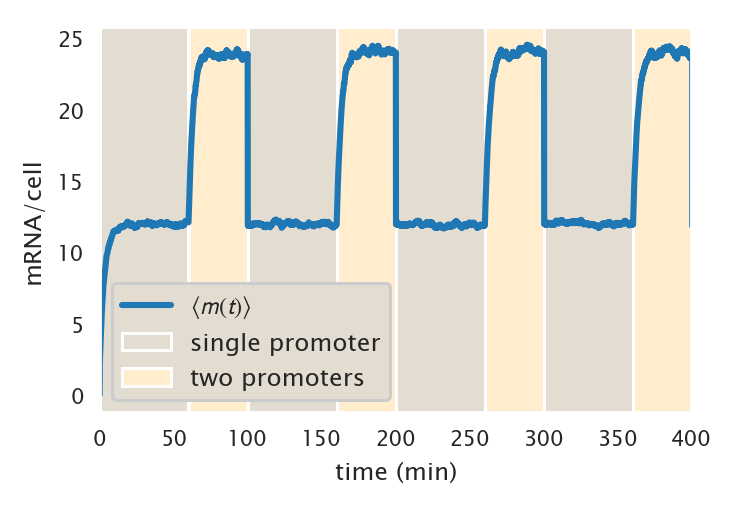

In [28]:
df_sim_mRNA = pd.read_csv(datadir + 'two_state_mRNA_gillespie.csv')
                          

# Group data by simulation number
df_group = df_sim_mRNA.groupby('sim_num')

# Initialize plot
fig = plt.figure()

# Compute mean mRNA
mean_mRNA =  [data.mRNA.mean() for group, data in df_sim_mRNA.groupby('time')]
# # Plot mean mRNA
plt.plot(time_points / 60, mean_mRNA, '-', lw=2,
         color=colors[1],
         label=r'$\left\langle m(t) \right\rangle$')

# Group data frame by cell cycle
df_group = df_sim_mRNA.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_sim_mRNA['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    plt.axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    plt.axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)

# Set limits
plt.xlim(df_sim_mRNA['time'].min() / 60, 
            df_sim_mRNA['time'].max() / 60)
# Label plot
plt.xlabel('time (min)')
plt.ylabel('mRNA/cell')
plt.legend()

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'mean_mRNA_two_state_gillespie.pdf')

Now that we have a heavier sampling of the distribution, let's look at the pseudo-steady-state distributions for both the single and double promoter. For this we will extract a single time point from the last cell cycle and plot the histogram over the 2500 simulations.

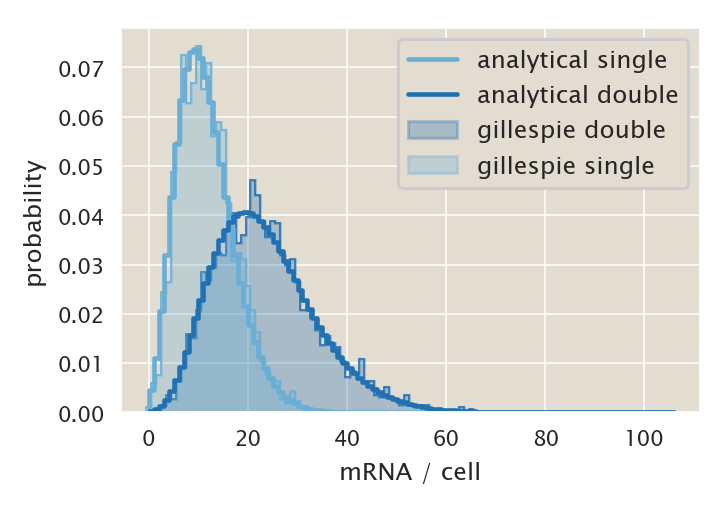

In [30]:
# Extract data from last cell cycle
df = df_sim_mRNA[df_sim_mRNA.cycle == df_sim_mRNA.cycle.max()]

# Determine bins for histogram
bins = np.arange(df.mRNA.max())

# Compute the probability
logp_mRNA_small = ccutils.model.log_p_m_unreg(bins, kp_on, kp_off,
                                              gm, rm)
logp_mRNA_large = ccutils.model.log_p_m_unreg(bins, kp_on, kp_off,
                                              gm, 2 * rm)

# Group by promoter state
df_group = df.groupby('state')

# Initialize figure
fig = plt.figure()

# Define colors for each group of cells
colors = np.flip(sns.color_palette('Blues', n_colors=3)[1::], axis=0)

# Loop through states
for i, (group, data) in enumerate(df_group):
    # Extract time
    time = np.sort(data.time.unique())
    # Extract mRNA data
    mRNA = data[data.time == time[-20]].mRNA
    # Histogram data
    plt.hist(mRNA, bins=bins, density=1, histtype='stepfilled',
             alpha=0.3, label='gillespie ' + group, align='left',
             color=colors[i], edgecolor=colors[i])
    plt.hist(mRNA, bins=bins, density=1, histtype='step',
             label='', align='left', lw=0.5,
             color=colors[i], edgecolor=colors[i])

# Plot theoretical predictions
plt.step(bins, np.exp(logp_mRNA_small), 
         color=colors[1], linestyle='-', lw=1.5,
         label='analytical single')
plt.step(bins, np.exp(logp_mRNA_large), 
         color=colors[0], linestyle='-', lw=1.5,
         label='analytical double')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
_ = plt.legend()
plt.tight_layout()

# Save figure
plt.savefig(figdir + 'theory_vs_sim_two_state_mRNA.pdf')

The agreement is great! As expected since the Gillespie algorithm is a numerical method to sample out of a master equation it needed to be the case that the simulation agrees with the closed-form solution of the master equation.

This shows that our implementation of the algorithm agrees with our analytical results. Now it is time to explore the protein distribution. This comparison will be important since the reason we implemented the MaxEnt approximation of the distribution is because we don't have the priviledge of having a solution for the distribution at the protein level.

## Two-state promoter protein level

In order to include the produciton of protein we need to re-define our propensity function to 1) keep track of the molecular count of proteins, and 2) include a protein production reaction.

Note that we did not mention protein degradation. For this work we assumed that all of the protein degradation came from binomial partitioning of the proteins due to cell division, so we did not include a stochastic degradation term for the protein.

In [31]:
numba.jit(nopython=True)
def two_state_prop_protein(population, kpon, kpoff, rm, gm, rp):
    '''
    Returns an array of the propensities given a set of parameters for a 
    two-sate promoter at the protein level
    
    Parameters
    ----------
    population : array-like.
        State of the molecule count for each of the species involved in the
        reaction. [active_promoter, inactive_promoter, mRNA]
    kpon, kpoff : float.
        Rates of transition between active and inactive promoter.
    rm, gm : float.
        Rate of mRNA production and degradation respectively.
    rp : float.
        Rate of protein production.
        
    Returns
    -------
    propensities : array-like
        Propensities for each of the reactions.
    '''
    # Unpack population
    a_prom, i_prom, m, p = population
    
    return np.array([i_prom * kpon,  # Transition from inactive to active
                     a_prom * kpoff,  # Transition from active to inactive
                     a_prom * rm,  # Production of mRNA
                     gm * m,  # Degradation mRNA
                     rp * m]  # Production of a protein
                    )

We also need to define an update matrix for this case where we keep track of the changes in protein copy number.

In [32]:
# Column 0 is change in active promoter
# Column 1 is change in inactive promoter
# Column 2 is change in mRNA counts
# Column 3 is change in protein counts
two_state_update = np.array([[1, -1, 0, 0],  # Transition inactive to active
                             [-1, 1, 0, 0],  # Transition active to inactive
                             [0, 0, 1, 0],   # Production of mRNA
                             [0, 0, -1, 0],  # Degradation of mRNA
                             [0, 0, 0, 1]],  # Production of protein 
                        dtype=np.int)

This is all we need! Everything else we have already code it so we can proceed directly into testing the simulation. 

For the **initial conditions** we won't start the simulations at 0 mRNA and 0 protein, but something closer to what we know should be the steady-state value. This is because otherwise we would need to run the simulations for too long in order to make any progress.

We will save the results not as a tidy data frame because for this case it would make our plotting very slow to have it in the long format.

In [108]:
# Define protein production rate
rp = 0.057 # sec**-1

# Specify parameters for calculation
args_single = np.array([kp_on, kp_off, rm, gm, rp])
args_double = np.array([kp_on, kp_off, 2 * rm, gm, rp])

# Define doubling time
doubling_time = 100
# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
single = 60 * t_single_frac * doubling_time # sec
double = 60 * (1 - t_single_frac) * doubling_time # sec
# Specify time points for each cell cycle
t_single = np.linspace(0, single, 500)
t_double = np.linspace(0, double, 500)
# Define cell cycle length
len_single = len(t_single)
len_double = len(t_double)
len_cycle = len_single + len_double

# Define number of simulations
n_simulations = 2500
# Initialize population
population_0 = np.array([1, 0, 12, 0], dtype=int)
population_0 =  np.tile(population_0, (n_simulations, 1))
# Set initial protein count to be binomially distributed
# with mean 6000
population_0[:, 3] = np.random.randint(0, 12000, n_simulations)


# Define number of cell cycles
n_cycles = 6

# Define entire time
time_points = np.array([0])
# Define copy number index
copy_idx = list()
# Define cycle index
cycle_idx = list()
for cyc in range(n_cycles):
    # Single-promoter time values
    time_points = np.append(time_points, t_single + time_points[-1] + 
                            np.diff(t_single)[0])
    # Two-promoter time values
    time_points = np.append(time_points, t_double + time_points[-1] + 
                            np.diff(t_double)[0])
    
    # Append index for copy number
    copy_idx = copy_idx + ['single'] * len_single
    copy_idx = copy_idx + ['double'] * len_double
    
    # Append index for cell cycle number
    cycle_idx = cycle_idx + [cyc] * len_cycle

# Remove first time point that was a place holder
time_points = time_points[1:]

pops = gillespie_cell_cycle(n_simulations, n_cycles, t_single, t_double,
                            args_single, args_double,
                            two_state_prop_protein, two_state_update,
                            population_0, [2, 3])

# Extract mRNA counts
pops_mRNA = pops[:,:,2]

# Extract protein count
pops_prot = pops[:,:,3]

# Set column titles for protein data frame
names = ['p' + str(i) for i in range(n_simulations)]

# Generate data frame
df_sim_prot = pd.DataFrame(pops_prot.T, columns=names)

# Set column titles for mRNA data frame
names = ['m' + str(i) for i in range(n_simulations)]

# Generate data frame
df = pd.DataFrame(pops_mRNA.T, columns=names)

# Append data frames
df_sim_prot = pd.concat([df_sim_prot, df],
                        axis=1, join_axes=[df_sim_prot.index])

# Add time
df_sim_prot['time'] = time_points
# Add cycle number
df_sim_prot['cycle'] = cycle_idx
# Add promoter state
df_sim_prot['state'] = copy_idx

# Save data frame
df_sim_prot.to_csv(datadir + 'two_state_protein_gillespie.csv')

df_sim_prot.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,m2493,m2494,m2495,m2496,m2497,m2498,m2499,time,cycle,state
0,6627,6862,8543,4812,9386,2016,4363,6881,8295,3838,...,12,12,12,12,12,12,12,7.214429,0,single
1,6639,6866,8546,4823,9389,2019,4367,6886,8298,3844,...,11,15,16,11,14,12,12,14.428858,0,single
2,6646,6874,8549,4829,9397,2022,4374,6893,8304,3851,...,11,20,15,11,13,10,15,21.643287,0,single
3,6653,6882,8554,4834,9403,2025,4376,6897,8308,3854,...,11,22,14,11,13,9,16,28.857715,0,single
4,6665,6888,8556,4840,9407,2028,4382,6902,8312,3856,...,11,22,23,11,12,9,16,36.072144,0,single


Let's take a look at the trajectories.

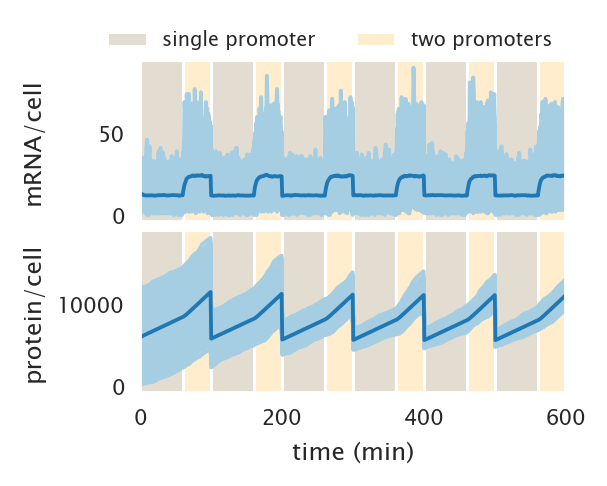

In [295]:
df_sim_prot = pd.read_csv(datadir + 'two_state_protein_gillespie.csv',
                          index_col=0)

# Extract mRNA data
mRNA_names = [x for x in df_sim_prot.columns 
              if re.match(r"[m]\d", x)]
mRNA_data = df_sim_prot.loc[:, mRNA_names].values
# Compute mean mRNA
mRNA_mean = mRNA_data.mean(axis=1)

# Extract protein data
protein_names = [x for x in df_sim_prot.columns 
                 if re.match(r"[p]\d", x)]
protein_data = df_sim_prot.loc[:, protein_names].values
# Compute mean protein
protein_mean = protein_data.mean(axis=1)

# Initialize plot
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2), sharex=True)

# Define colors
colors = sns.color_palette('Paired', n_colors=2)

# Define time stepsize for plot
binstep = 10
# Define every how many trajectories to plot
simnum = 10


# Plot mRNA trajectories
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean mRNA
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_mean[0::binstep],
           color=colors[1])

# Plot protein trajectories
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean protein
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_mean[0::binstep],
           color=colors[1])

# Group data frame by cell cycle
df_group = df_sim_prot.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_sim_prot['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)


# Set limits
ax[0].set_xlim(df_sim_prot['time'].min() / 60, 
            df_sim_prot['time'].max() / 60)
# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel('mRNA/cell')
ax[1].set_ylabel('protein/cell')

# Set legend for both plots
ax[0].legend(loc='upper left', ncol=2, frameon=False,
             bbox_to_anchor=(-0.12, 0, 0, 1.3), fontsize=6.5)

# Align y axis labels
fig.align_ylabels()

plt.subplots_adjust(hspace=0.05)

plt.savefig(figdir + 'two_state_mRNA_protein_gillespie.pdf',
            bbox_inches='tight')

The mean trajectories look quite similar to our MaxEnt approach. But for the case of the protein there is a much smaller variability compared to what we calculated with the ad hoc method we came up with for the MaxEnt approach.

Also, we only ran 2500 of these trajectories. Since we care about our protein space that has on the order of 20,000 possible values we would actually need on the order of 4$\times$10$^8$ simulations. This was definitely a very slow run, let's take a look and see how long it takes for one of these to run.

In [132]:
print('Time for single trajectory at protein level:')
%timeit gillespie_cell_cycle(1, n_cycles, t_single, t_double,\
                            args_single, args_double,\
                            two_state_prop_protein, two_state_update,\
                            np.array([[1,0,10,6000]]), [2, 3])

Time for single trajectory at protein level:
890 ms ± 42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So we have order 700 ms, which doesn't sound terrible. But let's do the math.
700 ms $\times$ 4$\times$10$^8 \sim$ 77,200 hours! And that is only for one of the distributions. For Fig. 5 in the main text we generated distributions for $\approx$ 50 different repressor copy numbers under 12 different inducer concentrations and 3 different operators. That is a on the order of 1800 distributions we would need to sample. Therefore the expected running time is on the order of > 10$^8$ hours, or 11,000 years of computational power.

It is obvious that this is not a feasible task. Even if we were to generate compiled code and we ran this on multiple cores it is unlikely that we could gain a factor of at least 10$^7$ hours. Having said that we can still compute the "dynamic steady-tate" protein distribution four our limited number of samples in order to compare this result to our MaxEnt approach.

### Computing the protein distribution.

In order to compute the protein distribution over the cell cycle we will follow the same procedure as we did for the MaxEnt approach. To compute the probability of having certain protein copy number $P(p)$ we must compute
$$
P(p) = \int_{\text{beginning cell cycle}}^{\text{end cell cycle}} dt \;
P(p \mid t) \rho(t),
$$
where $P(p \mid t)$ is the probability of having $p$ proteins at time $t$, and $\rho(t)$ is the probability of a cell being at time $t$ in its cell cycle. As before instead of working with time we can integrate over fraction of cell cycle $a \in [0, 1]$ as
$$
P(p) = \int_{0}^{1} da \; P(p \mid t) \rho(a),
$$
where we showed that $\rho(a)$ is of the form
$$
\rho(a) = \ln(2)\cdot 2^{1 - a}.
$$

First what we need to do is to generate a histogram of all protein values for each of the time points we have in the simulation.

In [296]:
# Extract information from last cell cycle
idx = np.where(df_sim_prot.cycle == df_sim_prot.cycle.max())
protein_data = protein_data[idx, :]

# Define unique time points
time = df_sim_prot.iloc[idx]['time']

# Define bins
bins = np.arange(0, protein_data.max())

# Initialize matrix to save histograms for each time point
histograms = np.zeros([len(bins) - 1, len(time)])

# Loop through time points and generate distributions
for i, t in enumerate(time):
    # Generate and save histogram
    histograms[:, i] = np.histogram(protein_data[:, i], bins,
                                    density=1)[0]

Now we can numerically perform the integral to compute the probability of each protein copy number

In [297]:
# Initialize array to save protein distribution
Pp = np.zeros(len(bins))

# Compute the time differences
time_diff = np.diff(time)

# Compute the cumulative time difference
time_cumsum = np.cumsum(time_diff)
time_cumsum = time_cumsum / time_cumsum[-1]

# Define array for spacing of cell cycle
a_array = np.zeros(len(time))
a_array[1:] = time_cumsum 

# Compute probability based on this array
p_a_array = np.log(2) * 2**(1 - a_array)

# Loop through each of the protein copy numbers
for p in bins[:-1]:
    # Perform numerical integration
    Pp[p] = sp.integrate.simps(histograms[p, :] * p_a_array,
                                      a_array)

Time to look at the resulting protein distribution.

Text(0, 0.5, 'probability')

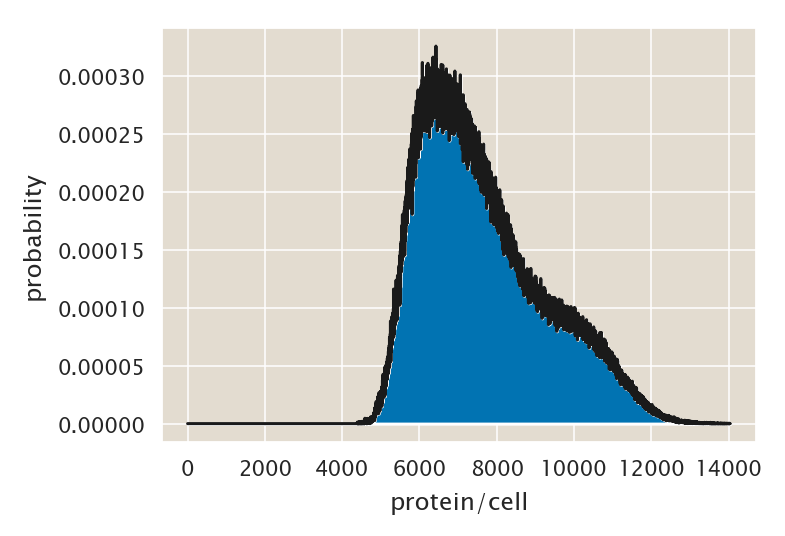

In [145]:
# Define binstep for plot, meaning how often to plot
# an entry
binstep = 1

# Generate PMF plot
plt.plot(bins[0::binstep], Pp[0::binstep], drawstyle='steps', 
         lw=1, color='k')
# Fill between histogram
plt.fill_between(bins[0::binstep], Pp[0::binstep],
                 alpha=1, step='pre')

plt.xlabel('protein/cell')
plt.ylabel('probability')
# 

This doesn't look too promising. The fact that there is zero probability of having zero proteins differs from what we calculated with the MaxEnt approach.

### Comparison with experimental data

Now that we have this distribution we can compare it with the experimental data. Let's first import the microscopy datasets.

In [301]:
# Read the tidy-data frame
files = glob.glob('../../data/csv_microscopy/*IPTG*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)

##  Remove data sets that are ignored because of problems with the data quality
##  NOTE: These data sets are kept in the repository for transparency, but they
##  failed at one of our quality criteria
##  (see README.txt file in microscopy folder)
ignore_files = [x for x in os.listdir('../image_analysis/ignore_datasets/')
                if 'microscopy' in x]
# Extract data from these files
ignore_dates = [int(x.split('_')[0]) for x in ignore_files]

# Remove these dates
df_micro = df_micro[~df_micro['date'].isin(ignore_dates)].reset_index()

df_micro[['date', 'operator', 'rbs', 'mean_intensity', 'intensity']].head()

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,date,operator,rbs,mean_intensity,intensity
0,20181018,O2,auto,88.876915,502.830035
1,20181018,O2,auto,99.759342,393.291230
2,20181018,O2,auto,94.213193,552.315421
3,20181018,O2,auto,92.993102,426.131591
4,20181018,O2,auto,94.591855,455.251678


Now in order to compare the scales we will normalize by the mean intensity of the $\Delta lacI$ strain on each data set. This is equivalent to computing the fold-change in gene expression for each of the cells with respect to the mean fluroescence level.

In [302]:
# group df by date
df_group = df_micro.groupby('date')

# loop through dates
for group, data in df_group:
    # Extract mean autofluorescence
    mean_auto = data[data.rbs == 'auto'].intensity.mean()
    # Extract mean ∆lacI
    mean_delta = data[data.rbs == 'delta'].intensity.mean() 
    # Compute fold-change
    fc = (data.intensity - mean_auto) / (mean_delta - mean_auto)
    # Add result to original dataframe
    df_micro.loc[fc.index, 'fold_change'] = fc
    

df_micro[['date', 'operator', 'rbs', 'mean_intensity',
          'intensity', 'fold_change']].head()

,date,operator,rbs,mean_intensity,intensity,fold_change
0,20181018,O2,auto,88.876915,502.830035,0.014262
1,20181018,O2,auto,99.759342,393.291230,-0.002006
2,20181018,O2,auto,94.213193,552.315421,0.021610
3,20181018,O2,auto,92.993102,426.131591,0.002871
4,20181018,O2,auto,94.591855,455.251678,0.007196


Let's now compare the $\Delta lacI$ experimental distributions with our results from the Gillespie simulation.

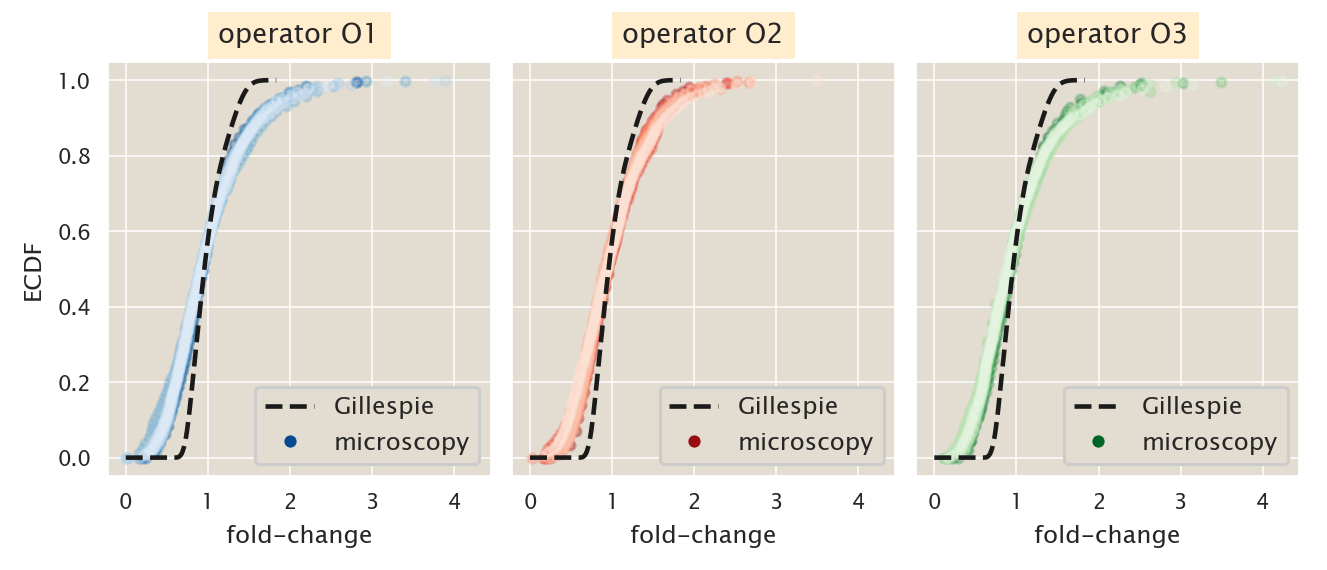

In [304]:
# Compute mean protein copy number
mean_delta_p = np.sum(bins * Pp)

# Transform protein_space into fold-change
fc_space = bins / mean_delta_p

##  Plot ECDF for experimental data
# Keep only data for ∆lacI
df_delta = df_micro[df_micro.rbs == 'delta']

# Group data by operator
df_group = df_delta.groupby('operator')

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5),
                       sharex=True, sharey=True)

# Define colors for operators
col_list = ['Blues_r', 'Reds_r', 'Greens_r']
col_dict = dict(zip(('O1', 'O2', 'O3'), col_list))

# Loop through operators
for i, (group, data) in enumerate(df_group):
    # Group data by date
    data_group = data.groupby('date')
    # Generate list of colors
    colors = sns.color_palette(col_dict[group], n_colors=len(data_group))
    
    # Loop through dates
    for j, (g, d) in enumerate(data_group):
        # Generate ECDF
        x, y = ccutils.stats.ecdf(d.fold_change)
        # Plot ECDF
        ax[i].plot(x[::10], y[::10], lw=0, marker='.', color=colors[j],
                   alpha=0.3, label='')
        
    # Label x axis
    ax[i].set_xlabel('fold-change')
    # Set title
    label = r'operator {:s}'.format(group)
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    
    # Plot theoretical prediction
    ax[i].plot(fc_space[0::100], 
               np.cumsum(Pp)[0::100],
               linestyle='--', color='k',
               linewidth=1.5, label='Gillespie')
    
    # Add fake data point for legend
    ax[i].plot([], [], lw=0, marker='.', color=colors[0],
               label='microscopy')
    # Add legend
    ax[i].legend()
    
# Label y axis of left plot
ax[0].set_ylabel('ECDF')


# Change spacing between plots
plt.subplots_adjust(wspace=0.05)

plt.savefig(figdir + 'gillespie_vs_data.pdf', bbox_inches='tight')

Not good. There is an obvious systematic deviation from what we observed experimentally. The agrement with our ad hoc MaxEnt method was much better than this.

### Comparison with MaxEnt approach

To complete the comparison let's now look at the resultin distribution from the MaxEnt approach. For this we need to import the corresponding Lagrange multipliers.

In [305]:
# Define directory for MaxEnt data
maxentdir = '../../data/csv_maxEnt_dist/'
# Read resulting values for the multipliers.
df_maxEnt = pd.read_csv(maxentdir + 'MaxEnt_Lagrange_mult_protein.csv')
df_maxEnt.head()

,operator,binding_energy,repressor,inducer_uM,lambda_m0p1,lambda_m0p2,lambda_m0p3,lambda_m0p4,lambda_m0p5,lambda_m0p6,...,m3p0,m3p1,m3p2,m3p3,m4p0,m4p1,m4p2,m5p0,m5p1,m6p0
0,O1,-15.3,0.0,0.0,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08
1,O1,-15.3,0.0,0.1,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08
2,O1,-15.3,0.0,5.0,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08
3,O1,-15.3,0.0,10.0,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08
4,O1,-15.3,0.0,25.0,0.002918,-1.853543e-07,-3.375754e-13,6.208877e-18,-8.239236e-23,-3.409273e-28,...,8592.936386,7.866644e+07,7.435490e+11,7.223464e+15,278504.362303,2.639465e+09,2.564953e+13,1.054893e+07,1.023094e+11,4.526111e+08


Now let's define the necessary objects to build the distribution from these constraints obtained with the MaxEnt method.

In [306]:
# Extract protein moments in constraints
prot_mom =  [x for x in df_maxEnt.columns if 'm0' in x]
# Define index of moments to be used in the computation
moments = [tuple(map(int, re.findall(r'\d+', s))) for s in prot_mom]

# Define sample space
mRNA_space = np.array([0])
protein_space = np.arange(0, 1.9E4)

# Extract values to be used
df_sample = df_maxEnt[(df_maxEnt.operator == 'O1') &
                      (df_maxEnt.repressor == 0) &
                      (df_maxEnt.inducer_uM == 0)]


# Select the Lagrange multipliers
lagrange_sample =  df_sample.loc[:, [col for col in df_sample.columns 
                                 if 'lambda' in col]].values[0]

# Compute distribution from Lagrange multipliers values
Pp_maxEnt = ccutils.maxent.maxEnt_from_lagrange(mRNA_space, 
                                                protein_space, 
                                                lagrange_sample,
                                                exponents=moments).T[0]

Now we can compare both distributions. For this case since both of them were calculated using the same parameters we don't need to normalize by the mean expression or anything like that. We can do a honest one-to-one comparison between results.

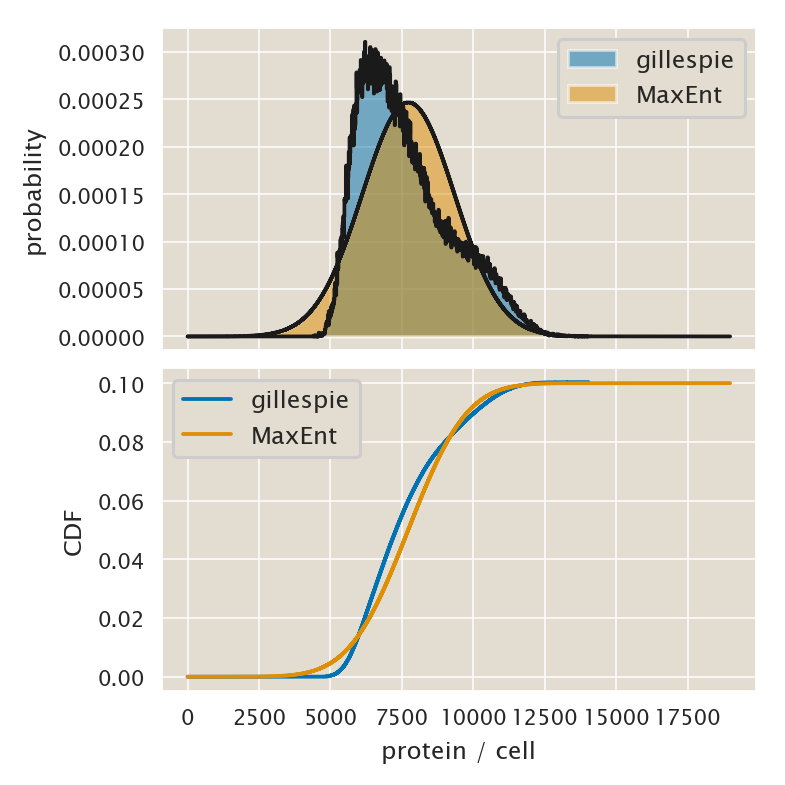

In [307]:
# Define binstep for plot, meaning how often to plot
# an entry
binstep = 10

# Initialize figure
fig, ax = plt.subplots(2, 1, figsize=(3.5,4),
                       sharex=True)

# Plot gillespie results
ax[0].plot(bins[0::binstep], Pp[0::binstep],
           drawstyle='steps', color='k')
ax[0].fill_between(bins[0::binstep], Pp[0::binstep],
                   step='pre', alpha=0.5, label='gillespie')
ax[1].plot(bins[0::binstep], np.cumsum(Pp[0::binstep]),
         drawstyle='steps', label='gillespie')

# Plot MaxEnt results
ax[0].plot(protein_space[0::binstep], Pp_maxEnt[0::binstep],
           drawstyle='steps', color='k')
ax[0].fill_between(protein_space[0::binstep], Pp_maxEnt[0::binstep],
                   step='pre', alpha=0.5, label='MaxEnt')
ax[1].plot(protein_space[0::binstep], np.cumsum(Pp_maxEnt[0::binstep]),
         drawstyle='steps', label='MaxEnt')

# Add legend
ax[0].legend()
ax[1].legend()
# Label axis
ax[0].set_ylabel('probability')
ax[1].set_ylabel('CDF')
ax[1].set_xlabel('protein / cell')

# Change spacing between plots
plt.subplots_adjust(hspace=0.05)

# Save figure
plt.savefig(figdir + 'gillespie_maxEnt_comparison.pdf',
            bbox_inches='tight')

These are clearly different, and that is no bueno.

Let's try to systematically test different ideas that could explain the differences we observe.

## Test #1: Lower protein copy number.

The first thing we will try will be to have a smaller mean protein per mRNA to see if the fluctuations are amplified during the binomial partitioing.

In [181]:
# Define protein production rate
rp = 0.0022 # sec**-1

# Specify parameters for calculation
args_single = np.array([kp_on, kp_off, rm, gm, rp])
args_double = np.array([kp_on, kp_off, 2 * rm, gm, rp])

# Define doubling time
doubling_time = 100
# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
single = 60 * t_single_frac * doubling_time # sec
double = 60 * (1 - t_single_frac) * doubling_time # sec
# Specify time points for each cell cycle
t_single = np.linspace(0, single, 500)
t_double = np.linspace(0, double, 500)
# Define cell cycle length
len_single = len(t_single)
len_double = len(t_double)
len_cycle = len_single + len_double

# Define number of simulations
n_simulations = 1000
# Initialize population
population_0 = np.array([1, 0, 12, 0], dtype=int)
population_0 =  np.tile(population_0, (n_simulations, 1))
# Set initial protein count
population_0[:, 3] = np.random.randint(0, 1000, n_simulations)

# Define number of cell cycles
n_cycles = 6

# Define entire time
time_points = np.array([0])
# Define copy number index
copy_idx = list()
# Define cycle index
cycle_idx = list()
for cyc in range(n_cycles):
    # Single-promoter time values
    time_points = np.append(time_points, t_single + time_points[-1] + 
                            np.diff(t_single)[0])
    # Two-promoter time values
    time_points = np.append(time_points, t_double + time_points[-1] + 
                            np.diff(t_double)[0])
    
    # Append index for copy number
    copy_idx = copy_idx + ['single'] * len_single
    copy_idx = copy_idx + ['double'] * len_double
    
    # Append index for cell cycle number
    cycle_idx = cycle_idx + [cyc] * len_cycle

# Remove first time point that was a place holder
time_points = time_points[1:]

pops = gillespie_cell_cycle(n_simulations, n_cycles, t_single, t_double,
                            args_single, args_double,
                            two_state_prop_protein, two_state_update,
                            population_0, [2, 3])

# Extract mRNA counts
pops_mRNA = pops[:,:,2]

# Extract protein count
pops_prot = pops[:,:,3]

# Set column titles for protein data frame
names = ['p' + str(i) for i in range(n_simulations)]

# Generate data frame
df_sim_prot = pd.DataFrame(pops_prot.T, columns=names)

# Set column titles for mRNA data frame
names = ['m' + str(i) for i in range(n_simulations)]

# Generate data frame
df = pd.DataFrame(pops_mRNA.T, columns=names)

# Append data frames
df_sim_prot = pd.concat([df_sim_prot, df],
                        axis=1, join_axes=[df_sim_prot.index])

# Add time
df_sim_prot['time'] = time_points
# Add cycle number
df_sim_prot['cycle'] = cycle_idx
# Add promoter state
df_sim_prot['state'] = copy_idx

# Save data frame
df_sim_prot.to_csv(datadir + 'two_state_protein_gillespie_test1.csv')

df_sim_prot.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,m993,m994,m995,m996,m997,m998,m999,time,cycle,state
0,494,835,932,809,461,511,383,783,593,111,...,12,12,12,12,12,12,12,7.214429,0,single
1,494,835,932,809,461,513,383,784,593,111,...,14,11,14,14,12,18,12,14.428858,0,single
2,494,835,933,809,461,513,383,785,593,111,...,13,10,14,14,12,16,12,21.643287,0,single
3,495,836,933,809,461,513,384,785,594,111,...,13,9,14,13,12,15,12,28.857715,0,single
4,495,838,933,809,462,514,384,785,595,113,...,12,9,12,12,12,15,12,36.072144,0,single


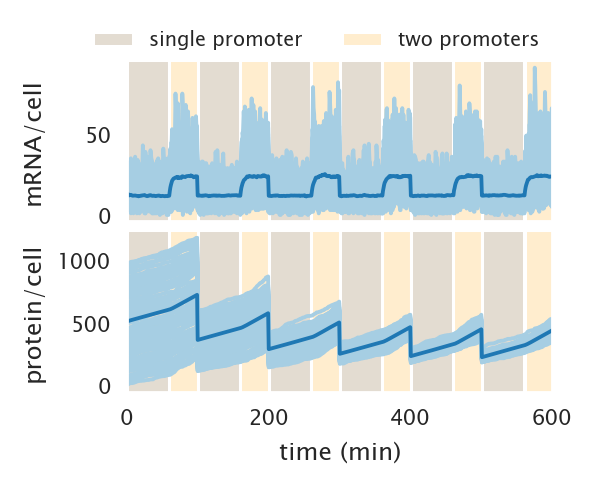

In [203]:
df_sim_prot = pd.read_csv(datadir + 'two_state_protein_gillespie_test1.csv',
                          index_col=0)

# Extract mRNA data
mRNA_names = [x for x in df_sim_prot.columns 
              if re.match(r"[m]\d", x)]
mRNA_data = df_sim_prot.loc[:, mRNA_names].values
# Compute mean mRNA
mRNA_mean = mRNA_data.mean(axis=1)

# Extract protein data
protein_names = [x for x in df_sim_prot.columns 
                 if re.match(r"[p]\d", x)]
protein_data = df_sim_prot.loc[:, protein_names].values
# Compute mean protein
protein_mean = protein_data.mean(axis=1)

# Initialize plot
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2), sharex=True)

# Define colors
colors = sns.color_palette('Paired', n_colors=2)

# Define time stepsize for plot
binstep = 10
# Define every how many trajectories to plot
simnum = 10


# Plot mRNA trajectories
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean mRNA
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_mean[0::binstep],
           color=colors[1])

# Plot protein trajectories
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean protein
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_mean[0::binstep],
           color=colors[1])

# Group data frame by cell cycle
df_group = df_sim_prot.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_sim_prot['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)


# Set limits
ax[0].set_xlim(df_sim_prot['time'].min() / 60, 
            df_sim_prot['time'].max() / 60)
# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel('mRNA/cell')
ax[1].set_ylabel('protein/cell')

# Set legend for both plots
ax[0].legend(loc='upper left', ncol=2, frameon=False,
             bbox_to_anchor=(-0.12, 0, 0, 1.3), fontsize=6.5)

# Align y axis labels
fig.align_ylabels()

plt.subplots_adjust(hspace=0.05)

plt.savefig(figdir + 'two_state_mRNA_protein_gillespie_test1.pdf')

It seems that it again converges to a much smaller variance than expected.

Let's compute the protein distribution for the last cell cycle as before.

In [204]:
# Extract information from last cell cycle
idx = np.where(df_sim_prot.cycle == df_sim_prot.cycle.max())
protein_data = protein_data[idx, :]

# Define unique time points
time = df_sim_prot.iloc[idx]['time']
# Define bins
bins = np.arange(0, protein_data.max())

# Initialize matrix to save histograms for each time point
histograms = np.zeros([len(bins) - 1, len(time)])

# Loop through time points and generate distributions
for i, t in enumerate(time):
    # Generate and save histogram
    histograms[:, i] = np.histogram(protein_data[:, i], bins,
                                    density=1)[0]
    
# Initialize array to save protein distribution
Pp = np.zeros(len(bins))

# Compute the time differences
time_diff = np.diff(time)

# Compute the cumulative time difference
time_cumsum = np.cumsum(time_diff)
time_cumsum = time_cumsum / time_cumsum[-1]

# Define array for spacing of cell cycle
a_array = np.zeros(len(time))
a_array[1:] = time_cumsum 

# Compute probability based on this array
p_a_array = np.log(2) * 2**(1 - a_array)

# Loop through each of the protein copy numbers
for p in bins[:-1]:
    # Perform numerical integration
    Pp[p] = sp.integrate.simps(histograms[p, :] * p_a_array,
                                      a_array)

Let's take a look

Text(0, 0.5, 'probability')

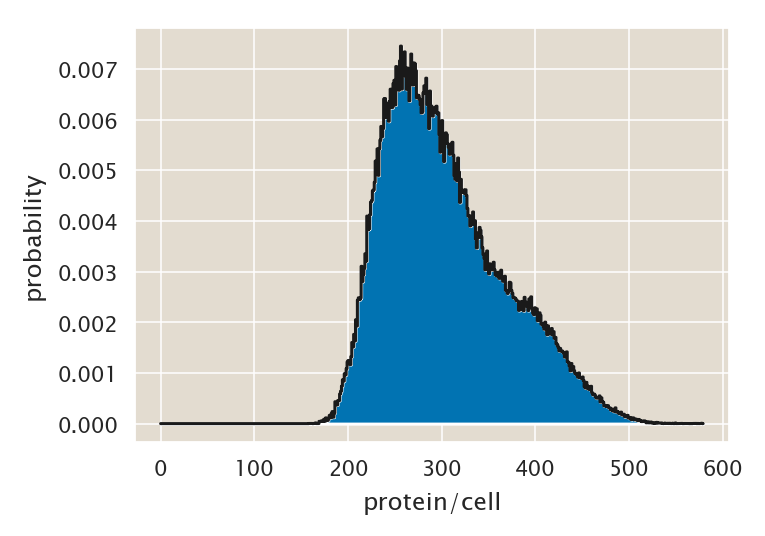

In [205]:
# Define binstep for plot, meaning how often to plot
# an entry
binstep = 1

# Generate PMF plot
plt.plot(bins[0::binstep], Pp[0::binstep], drawstyle='steps', 
         lw=1, color='k')
# Fill between histogram
plt.fill_between(bins[0::binstep], Pp[0::binstep],
                 alpha=1, step='pre')

plt.xlabel('protein/cell')
plt.ylabel('probability')

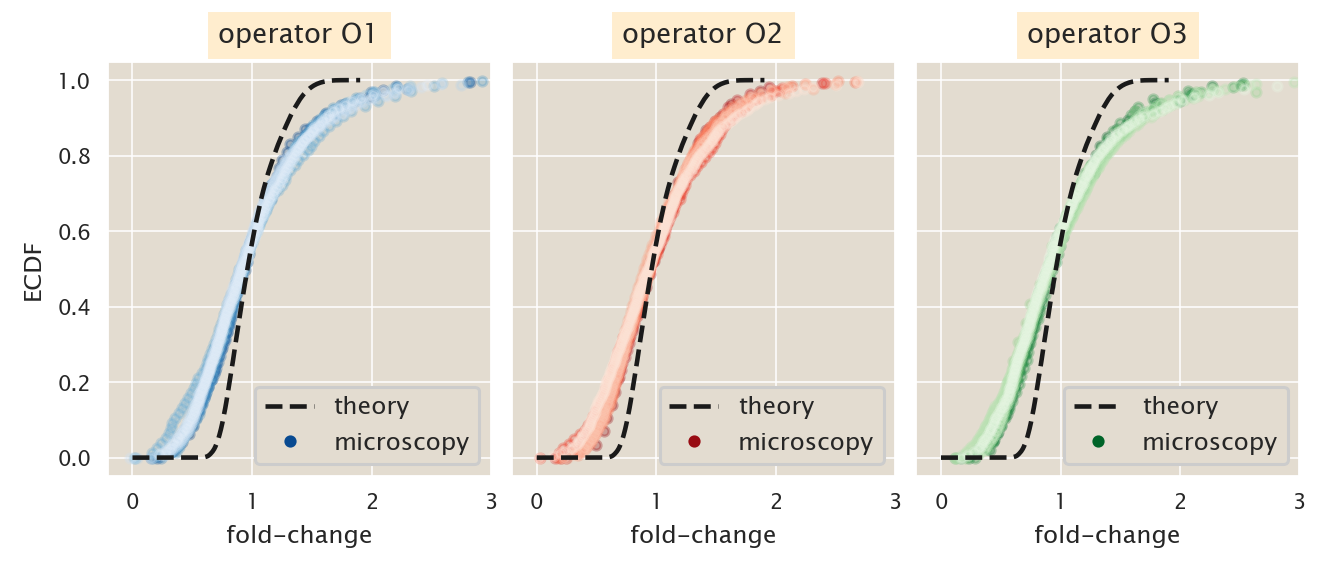

In [208]:
# Compute mean protein copy number
mean_delta_p = np.sum(bins * Pp)

# Transform protein_space into fold-change
fc_space = bins / mean_delta_p

##  Plot ECDF for experimental data
# Keep only data for ∆lacI
df_delta = df_micro[df_micro.rbs == 'delta']

# Group data by operator
df_group = df_delta.groupby('operator')

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5),
                       sharex=True, sharey=True)

# Define colors for operators
col_list = ['Blues_r', 'Reds_r', 'Greens_r']
col_dict = dict(zip(('O1', 'O2', 'O3'), col_list))

# Loop through operators
for i, (group, data) in enumerate(df_group):
    # Group data by date
    data_group = data.groupby('date')
    # Generate list of colors
    colors = sns.color_palette(col_dict[group], n_colors=len(data_group))
    
    # Loop through dates
    for j, (g, d) in enumerate(data_group):
        # Generate ECDF
        x, y = ccutils.stats.ecdf(d.fold_change)
        # Plot ECDF
        ax[i].plot(x[::10], y[::10], lw=0, marker='.', color=colors[j],
                   alpha=0.3, label='')
        
    # Label x axis
    ax[i].set_xlabel('fold-change')
    # Set title
    label = r'operator {:s}'.format(group)
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    
    # Plot theoretical prediction
    ax[i].plot(fc_space, 
               np.cumsum(Pp),
               linestyle='--', color='k',
               linewidth=1.5, label='theory')
    
    # Add fake data point for legend
    ax[i].plot([], [], lw=0, marker='.', color=colors[0],
               label='microscopy')
    # Add legend
    ax[i].legend()
    
    # Set limits
    ax[i].set_xlim(right=3)
    
# Label y axis of left plot
ax[0].set_ylabel('ECDF')


# Change spacing between plots
plt.subplots_adjust(wspace=0.05)

# Save figure
plt.savefig(figdir + 'gillespie_vs_data_test1.pdf')

Indeed this doesn't improve the agreement with the data.

## Test #2: Include protein degradation.

We will now include another possible stochastic reaction to our Gillespie simulation. We will allow the possibility of a protein being degraded with a mean life time of one cell division.

In [209]:
numba.jit(nopython=True)
def two_state_prop_protein_deg(population, kpon, kpoff, rm, gm, rp, gp):
    '''
    Returns an array of the propensities given a set of parameters for a 
    two-sate promoter at the protein level
    
    Parameters
    ----------
    population : array-like.
        State of the molecule count for each of the species involved in the
        reaction. [active_promoter, inactive_promoter, mRNA]
    kpon, kpoff : float.
        Rates of transition between active and inactive promoter.
    rm, gm : float.
        Rate of mRNA production and degradation respectively.
    rp : float.
        Rate of protein production.
    gp : float.
        Rate of protein degradation.   
        
    Returns
    -------
    propensities : array-like
        Propensities for each of the reactions.
    '''
    # Unpack population
    a_prom, i_prom, m, p = population
    
    return np.array([i_prom * kpon,  # Transition from inactive to active
                     a_prom * kpoff,  # Transition from active to inactive
                     a_prom * rm,  # Production of mRNA
                     gm * m,  # Degradation mRNA
                     rp * m,  # Production of a protein
                     gp * p]  # Degradation of protein
                    )

# Column 0 is change in active promoter
# Column 1 is change in inactive promoter
# Column 2 is change in mRNA counts
# Column 3 is change in protein counts
two_state_deg = np.array([[1, -1, 0, 0],  # Transition inactive to active
                          [-1, 1, 0, 0],  # Transition active to inactive
                          [0, 0, 1, 0],   # Production of mRNA
                          [0, 0, -1, 0],  # Degradation of mRNA
                          [0, 0, 0, 1],   # Production of protein 
                          [0, 0, 0, -1]], # Degradation of protein 
                        dtype=np.int)

Before running the real simulation, let's make sure that the propensity function works properly by performing a simulation without cell division.

In [288]:
# Define protein parameters
rp = 0.057
gp = 1 / (60 * 100)
# Specify parameters for calculation
args = np.array([kp_on, kp_off, rm, gm, rp, gp])
time_points = np.linspace(0, 10000, 1000)
population_0 = np.array([1, 0, 0, 4000], dtype=int)
n_simulations = 500

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), len(population_0)),
                dtype=int)

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa_fast(two_state_prop_protein_deg,
                                     two_state_deg,
                                     population_0, time_points, args=args)

Let's look at the protein trajectories now.

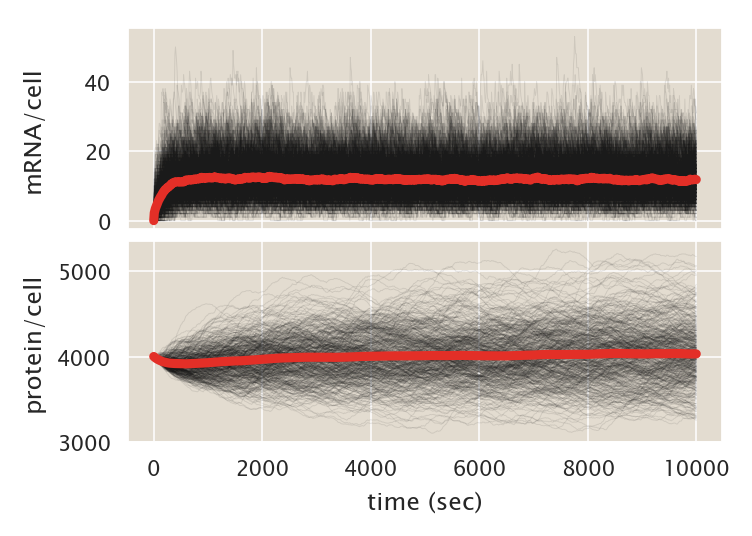

In [289]:
# Initialize plot
fig, ax = plt.subplots(2, 1, sharex=True)

# Loop through trajectories
for i in range(n_simulations):
    # Plot mRNA
    ax[0].plot(time_points, pops[i,:,2], '-', lw=0.3, alpha=0.1,
             color='k')
    # Plot protein
    ax[1].plot(time_points, pops[i,:,3], '-', lw=0.3, alpha=0.1,
             color='k')
    
# Plot mean mRNA
ax[0].plot(time_points, pops[:, :, 2].mean(axis=0), '-', lw=3,
         color=sns.color_palette('Reds_r', n_colors=2)[0])
# Plot mean protein
ax[1].plot(time_points, pops[:, :, 3].mean(axis=0), '-', lw=3,
         color=sns.color_palette('Reds_r', n_colors=2)[0])

# Label axis
ax[1].set_xlabel('time (sec)')
ax[0].set_ylabel('mRNA/cell')
ax[1].set_ylabel('protein/cell')

# Align y axis labels
fig.align_ylabels()

plt.subplots_adjust(hspace=0.05)

The protein reaches the expected mean steady state, so we can assess that the simulation are working as expected. Now we can run the simulations including he cell cycle variation.

In [210]:
# Define protein production rate
rp = 0.057 # sec**-1
gp = 1 / (60 * 100) # sec**-1

# Specify parameters for calculation
args_single = np.array([kp_on, kp_off, rm, gm, rp, gp])
args_double = np.array([kp_on, kp_off, 2 * rm, gm, rp, gp])

# Define doubling time
doubling_time = 100
# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
single = 60 * t_single_frac * doubling_time # sec
double = 60 * (1 - t_single_frac) * doubling_time # sec
# Specify time points for each cell cycle
t_single = np.linspace(0, single, 500)
t_double = np.linspace(0, double, 500)
# Define cell cycle length
len_single = len(t_single)
len_double = len(t_double)
len_cycle = len_single + len_double

# Define number of simulations
n_simulations = 1000
# Initialize population
population_0 = np.array([1, 0, 12, 0], dtype=int)
population_0 =  np.tile(population_0, (n_simulations, 1))
# Set initial protein count to be binomially distributed
# with mean 6000
population_0[:, 3] = np.random.randint(0, 12000, n_simulations)


# Define number of cell cycles
n_cycles = 6

# Define entire time
time_points = np.array([0])
# Define copy number index
copy_idx = list()
# Define cycle index
cycle_idx = list()
for cyc in range(n_cycles):
    # Single-promoter time values
    time_points = np.append(time_points, t_single + time_points[-1] + 
                            np.diff(t_single)[0])
    # Two-promoter time values
    time_points = np.append(time_points, t_double + time_points[-1] + 
                            np.diff(t_double)[0])
    
    # Append index for copy number
    copy_idx = copy_idx + ['single'] * len_single
    copy_idx = copy_idx + ['double'] * len_double
    
    # Append index for cell cycle number
    cycle_idx = cycle_idx + [cyc] * len_cycle

# Remove first time point that was a place holder
time_points = time_points[1:]

pops = gillespie_cell_cycle(n_simulations, n_cycles, t_single, t_double,
                            args_single, args_double,
                            two_state_prop_protein_deg, two_state_deg,
                            population_0, [2, 3])

# Extract mRNA counts
pops_mRNA = pops[:,:,2]

# Extract protein count
pops_prot = pops[:,:,3]

# Set column titles for protein data frame
names = ['p' + str(i) for i in range(n_simulations)]

# Generate data frame
df_sim_prot = pd.DataFrame(pops_prot.T, columns=names)

# Set column titles for mRNA data frame
names = ['m' + str(i) for i in range(n_simulations)]

# Generate data frame
df = pd.DataFrame(pops_mRNA.T, columns=names)

# Append data frames
df_sim_prot = pd.concat([df_sim_prot, df],
                        axis=1, join_axes=[df_sim_prot.index])

# Add time
df_sim_prot['time'] = time_points
# Add cycle number
df_sim_prot['cycle'] = cycle_idx
# Add promoter state
df_sim_prot['state'] = copy_idx

# Save data frame
df_sim_prot.to_csv(datadir + 'two_state_protein_gillespie_test2.csv')

df_sim_prot.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,m993,m994,m995,m996,m997,m998,m999,time,cycle,state
0,7992,9368,4734,5318,3097,2964,2871,570,3086,10062,...,12,12,12,12,12,12,12,7.214429,0,single
1,7992,9363,4745,5316,3098,2967,2872,582,3089,10054,...,15,14,13,12,13,12,17,14.428858,0,single
2,7994,9361,4749,5309,3101,2972,2879,590,3090,10048,...,14,14,13,16,13,12,14,21.643287,0,single
3,7993,9350,4753,5306,3105,2974,2887,595,3097,10047,...,12,14,15,14,13,12,14,28.857715,0,single
4,7991,9343,4751,5309,3105,2983,2890,600,3098,10042,...,12,14,17,14,13,11,14,36.072144,0,single


Let's take a look at the trajectories

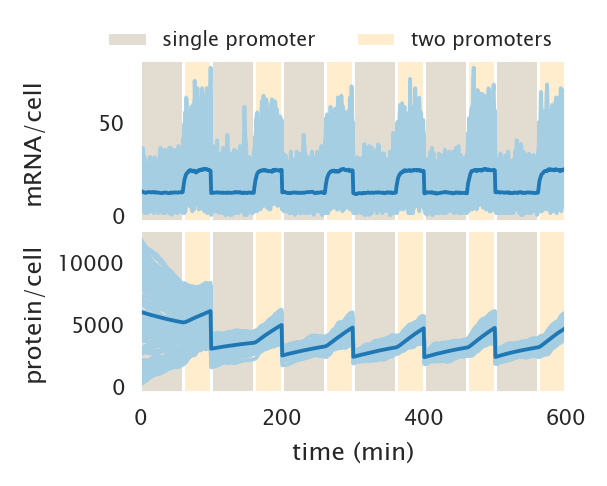

In [211]:
df_sim_prot = pd.read_csv(datadir + 'two_state_protein_gillespie_test2.csv',
                          index_col=0)

# Extract mRNA data
mRNA_names = [x for x in df_sim_prot.columns 
              if re.match(r"[m]\d", x)]
mRNA_data = df_sim_prot.loc[:, mRNA_names].values
# Compute mean mRNA
mRNA_mean = mRNA_data.mean(axis=1)

# Extract protein data
protein_names = [x for x in df_sim_prot.columns 
                 if re.match(r"[p]\d", x)]
protein_data = df_sim_prot.loc[:, protein_names].values
# Compute mean protein
protein_mean = protein_data.mean(axis=1)

# Initialize plot
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2), sharex=True)

# Define colors
colors = sns.color_palette('Paired', n_colors=2)

# Define time stepsize for plot
binstep = 10
# Define every how many trajectories to plot
simnum = 10


# Plot mRNA trajectories
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean mRNA
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_mean[0::binstep],
           color=colors[1])

# Plot protein trajectories
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean protein
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_mean[0::binstep],
           color=colors[1])

# Group data frame by cell cycle
df_group = df_sim_prot.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_sim_prot['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)


# Set limits
ax[0].set_xlim(df_sim_prot['time'].min() / 60, 
            df_sim_prot['time'].max() / 60)
# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel('mRNA/cell')
ax[1].set_ylabel('protein/cell')

# Set legend for both plots
ax[0].legend(loc='upper left', ncol=2, frameon=False,
             bbox_to_anchor=(-0.12, 0, 0, 1.3), fontsize=6.5)

# Align y axis labels
fig.align_ylabels()

plt.subplots_adjust(hspace=0.05)

plt.savefig(figdir + 'two_state_mRNA_protein_gillespie_test2.pdf')

It quickly converges again to a much smaller variance than expected. Let's compute the distribution.

In [212]:
# Extract information from last cell cycle
idx = np.where(df_sim_prot.cycle == df_sim_prot.cycle.max())
protein_data = protein_data[idx, :]

# Define unique time points
time = df_sim_prot.iloc[idx]['time']
# Define bins
bins = np.arange(0, protein_data.max())

# Initialize matrix to save histograms for each time point
histograms = np.zeros([len(bins) - 1, len(time)])

# Loop through time points and generate distributions
for i, t in enumerate(time):
    # Generate and save histogram
    histograms[:, i] = np.histogram(protein_data[:, i], bins,
                                    density=1)[0]
    
# Initialize array to save protein distribution
Pp = np.zeros(len(bins))

# Compute the time differences
time_diff = np.diff(time)

# Compute the cumulative time difference
time_cumsum = np.cumsum(time_diff)
time_cumsum = time_cumsum / time_cumsum[-1]

# Define array for spacing of cell cycle
a_array = np.zeros(len(time))
a_array[1:] = time_cumsum 

# Compute probability based on this array
p_a_array = np.log(2) * 2**(1 - a_array)

# Loop through each of the protein copy numbers
for p in bins[:-1]:
    # Perform numerical integration
    Pp[p] = sp.integrate.simps(histograms[p, :] * p_a_array,
                                      a_array)

And now we take a look.

Text(0, 0.5, 'probability')

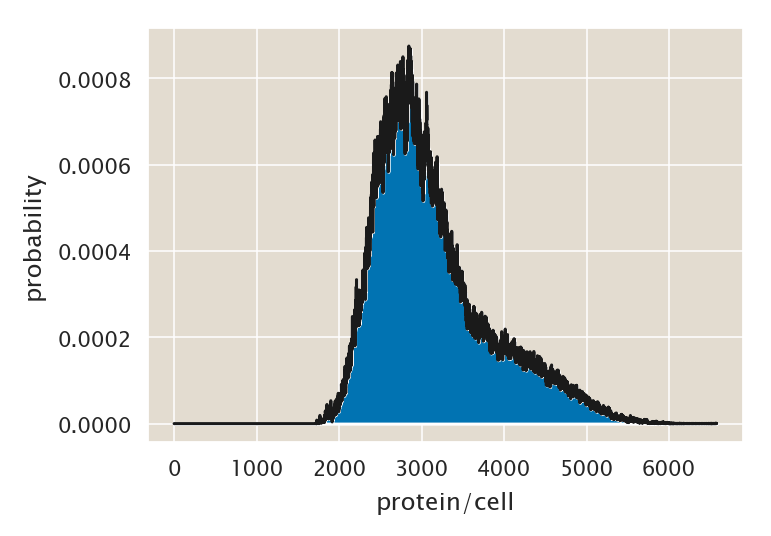

In [213]:
# Define binstep for plot, meaning how often to plot
# an entry
binstep = 1

# Generate PMF plot
plt.plot(bins[0::binstep], Pp[0::binstep], drawstyle='steps', 
         lw=1, color='k')
# Fill between histogram
plt.fill_between(bins[0::binstep], Pp[0::binstep],
                 alpha=1, step='pre')

plt.xlabel('protein/cell')
plt.ylabel('probability')

This still presents the same issue of having probability zero for low protien copy numbers. So it didn't resolve the issue. Let's plot again the simulations and the data.

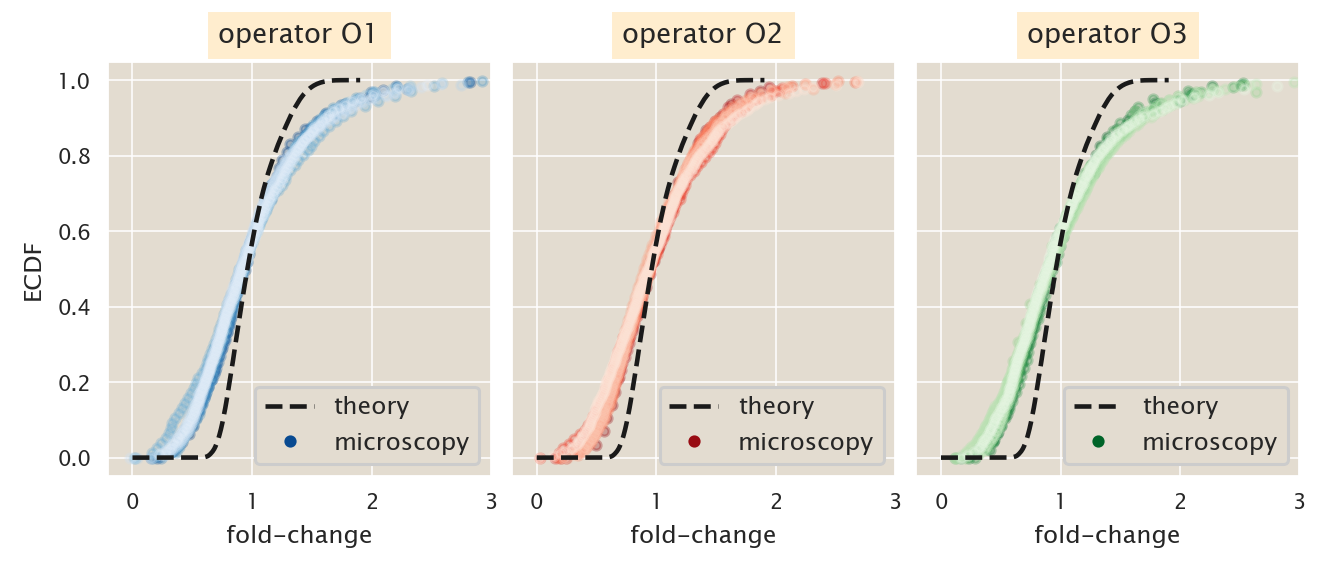

In [208]:
# Compute mean protein copy number
mean_delta_p = np.sum(bins * Pp)

# Transform protein_space into fold-change
fc_space = bins / mean_delta_p

##  Plot ECDF for experimental data
# Keep only data for ∆lacI
df_delta = df_micro[df_micro.rbs == 'delta']

# Group data by operator
df_group = df_delta.groupby('operator')

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5),
                       sharex=True, sharey=True)

# Define colors for operators
col_list = ['Blues_r', 'Reds_r', 'Greens_r']
col_dict = dict(zip(('O1', 'O2', 'O3'), col_list))

# Loop through operators
for i, (group, data) in enumerate(df_group):
    # Group data by date
    data_group = data.groupby('date')
    # Generate list of colors
    colors = sns.color_palette(col_dict[group], n_colors=len(data_group))
    
    # Loop through dates
    for j, (g, d) in enumerate(data_group):
        # Generate ECDF
        x, y = ccutils.stats.ecdf(d.fold_change)
        # Plot ECDF
        ax[i].plot(x[::10], y[::10], lw=0, marker='.', color=colors[j],
                   alpha=0.3, label='')
        
    # Label x axis
    ax[i].set_xlabel('fold-change')
    # Set title
    label = r'operator {:s}'.format(group)
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    
    # Plot theoretical prediction
    ax[i].plot(fc_space, 
               np.cumsum(Pp),
               linestyle='--', color='k',
               linewidth=1.5, label='theory')
    
    # Add fake data point for legend
    ax[i].plot([], [], lw=0, marker='.', color=colors[0],
               label='microscopy')
    # Add legend
    ax[i].legend()
    
    # Set limits
    ax[i].set_xlim(right=3)
    
# Label y axis of left plot
ax[0].set_ylabel('ECDF')


# Change spacing between plots
plt.subplots_adjust(wspace=0.05)

# Save figure
plt.savefig(figdir + 'gillespie_vs_data_test2.pdf')

## Test #3: Including active degradation only during cell division.

From this reference:
Nishi, A., & Kogoma, T. (1965). Protein turnover in the cell cycle of Escherichia coli. Journal of Bacteriology, 90(4), 884–890.

The authors suggest there is an active production and degradation of the proteome during cell fission such that the overall protein level remains the same. As a first approach we will include an active degradation of the proteins at the moment of the cell division. This will be simulated with a coin toss to decide whether or not a protein is degraded.

In [217]:
def gillespie_cell_cycle_deg(n_simulations, n_cycles, t_single, t_double,
                             args_single, args_double,
                             propensity_func, update, population_0, 
                             binom_idx=[2, 3], deg_idx=[3], deg_prob=0.1):
    '''
    Parameters
    ----------
    n_simulations: int.
        Number of single trajectories to simulate.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    t_single : float.
        Time that cells spend with a single promoter copy
    t_double : float.
        Time that cells spend with a two promoter copies.
    args_single : tuple
        The set of parameters to be passed to propensity_func for cells with
        a single copy of the promoter.
    args_double : tuple
        The set of parameters to be passed to propensity_func for cells with
        two copies of the promoter.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (n_simulations x num_chemical_species)
        Array of initial populations of all chemical species.
    binom_idx : list, shape = population_0.shape
        Index that points at which values of the population will undergo a
        binomial partitioning to simulate each cell division.
    deg_idx : list, shape = population_0.shape
        Index that points at which values of the population will undergo an
        active degradation during cell division.
    deg_prob: float.
        Probability of a molecule being actively degraded during cell division

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    '''
    # Define cell cycle length
    len_single = len(t_single)
    len_double = len(t_double)
    len_cycle = len_single + len_double
    # Initialize output array
    pops = np.empty((n_simulations, n_cycles * len_cycle, 
                     population_0.shape[1]), dtype=int)
    
    # Set initial population for each trajectory
    pop_init = population_0.copy()

    # Loop through cell cycles
    for cyc in range(n_cycles):
        # Define positions to save cell cycle
        single_pos = [cyc * len_cycle, cyc * (len_cycle) + len_single]
        double_pos = [cyc * len_cycle + len_single, 
                      (cyc + 1) * len_cycle]
        
        # Simulate single-promoter strains
        for i in range(n_simulations):
            pops[i,single_pos[0]:single_pos[1],:] = \
            gillespie_ssa_fast(propensity_func, update,
                               pop_init[i, :], t_single, args=args_single)
        # Extract last time point as initial condition for next stage
        pop_init = pops[:, single_pos[1] - 1, :]
            
        # Simulate double-promoter strains
        for i in range(n_simulations):
            pops[i,double_pos[0]:double_pos[1],:] = \
            gillespie_ssa_fast(propensity_func, update,
                               pop_init[i, :], t_double, args=args_double)
    
        # Extract last time point as inital condition for next stage
        pop_init = pops[:, double_pos[1] - 1, :]
        
        # Simulate cell division as a binomial partitioning of molecules
        for b in binom_idx:
            pop_init[:, b] = np.random.binomial(pop_init[:, b], 0.5)
        
        # Simulate active cell degradation as a coin toss
        for d in deg_idx:
            pop_init[:, d] = np.random.binomial(pop_init[:, d], 1 - deg_prob)
            
    return pops

Having defined the function let's run a test.

In [218]:
# Define protein production rate
rp = 0.057 # sec**-1

# Specify parameters for calculation
args_single = np.array([kp_on, kp_off, rm, gm, rp])
args_double = np.array([kp_on, kp_off, 2 * rm, gm, rp])

# Define doubling time
doubling_time = 100
# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
single = 60 * t_single_frac * doubling_time # sec
double = 60 * (1 - t_single_frac) * doubling_time # sec
# Specify time points for each cell cycle
t_single = np.linspace(0, single, 500)
t_double = np.linspace(0, double, 500)
# Define cell cycle length
len_single = len(t_single)
len_double = len(t_double)
len_cycle = len_single + len_double

# Define number of simulations
n_simulations = 500
# Initialize population
population_0 = np.array([1, 0, 12, 0], dtype=int)
population_0 =  np.tile(population_0, (n_simulations, 1))
# Set initial protein count
population_0[:, 3] = np.random.randint(0, 12000, n_simulations)

# Define number of cell cycles
n_cycles = 6

# Define entire time
time_points = np.array([0])
# Define copy number index
copy_idx = list()
# Define cycle index
cycle_idx = list()
for cyc in range(n_cycles):
    # Single-promoter time values
    time_points = np.append(time_points, t_single + time_points[-1] + 
                            np.diff(t_single)[0])
    # Two-promoter time values
    time_points = np.append(time_points, t_double + time_points[-1] + 
                            np.diff(t_double)[0])
    
    # Append index for copy number
    copy_idx = copy_idx + ['single'] * len_single
    copy_idx = copy_idx + ['double'] * len_double
    
    # Append index for cell cycle number
    cycle_idx = cycle_idx + [cyc] * len_cycle

# Remove first time point that was a place holder
time_points = time_points[1:]

pops = gillespie_cell_cycle_deg(n_simulations, n_cycles, t_single, t_double,
                                args_single, args_double,
                                two_state_prop_protein, two_state_update,
                                population_0, [2, 3])

# Extract mRNA counts
pops_mRNA = pops[:,:,2]

# Extract protein count
pops_prot = pops[:,:,3]

# Set column titles for protein data frame
names = ['p' + str(i) for i in range(n_simulations)]

# Generate data frame
df_sim_prot = pd.DataFrame(pops_prot.T, columns=names)

# Set column titles for mRNA data frame
names = ['m' + str(i) for i in range(n_simulations)]

# Generate data frame
df = pd.DataFrame(pops_mRNA.T, columns=names)

# Append data frames
df_sim_prot = pd.concat([df_sim_prot, df],
                        axis=1, join_axes=[df_sim_prot.index])

# Add time
df_sim_prot['time'] = time_points
# Add cycle number
df_sim_prot['cycle'] = cycle_idx
# Add promoter state
df_sim_prot['state'] = copy_idx

# Save data frame
df_sim_prot.to_csv(datadir + 'two_state_protein_gillespie_test3.csv')

df_sim_prot.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,m493,m494,m495,m496,m497,m498,m499,time,cycle,state
0,6058,3426,9697,7720,11760,445,3128,208,5399,5874,...,12,12,12,12,12,12,12,7.214429,0,single
1,6065,3438,9700,7724,11765,448,3133,212,5402,5877,...,11,14,15,14,29,12,12,14.428858,0,single
2,6069,3446,9709,7728,11772,458,3136,215,5405,5878,...,10,13,13,14,36,11,12,21.643287,0,single
3,6073,3454,9713,7732,11782,470,3144,223,5409,5883,...,11,12,13,13,35,11,12,28.857715,0,single
4,6074,3458,9719,7736,11785,476,3151,230,5413,5887,...,11,15,13,12,35,9,12,36.072144,0,single


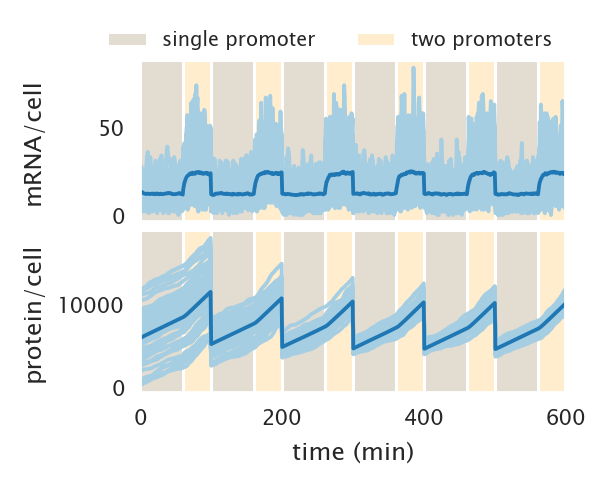

In [219]:
df_sim_prot = pd.read_csv(datadir + 'two_state_protein_gillespie_test3.csv',
                          index_col=0)

# Extract mRNA data
mRNA_names = [x for x in df_sim_prot.columns 
              if re.match(r"[m]\d", x)]
mRNA_data = df_sim_prot.loc[:, mRNA_names].values
# Compute mean mRNA
mRNA_mean = mRNA_data.mean(axis=1)

# Extract protein data
protein_names = [x for x in df_sim_prot.columns 
                 if re.match(r"[p]\d", x)]
protein_data = df_sim_prot.loc[:, protein_names].values
# Compute mean protein
protein_mean = protein_data.mean(axis=1)

# Initialize plot
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2), sharex=True)

# Define colors
colors = sns.color_palette('Paired', n_colors=2)

# Define time stepsize for plot
binstep = 10
# Define every how many trajectories to plot
simnum = 10


# Plot mRNA trajectories
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean mRNA
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_mean[0::binstep],
           color=colors[1])

# Plot protein trajectories
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean protein
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_mean[0::binstep],
           color=colors[1])

# Group data frame by cell cycle
df_group = df_sim_prot.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_sim_prot['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)


# Set limits
ax[0].set_xlim(df_sim_prot['time'].min() / 60, 
            df_sim_prot['time'].max() / 60)
# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel('mRNA/cell')
ax[1].set_ylabel('protein/cell')

# Set legend for both plots
ax[0].legend(loc='upper left', ncol=2, frameon=False,
             bbox_to_anchor=(-0.12, 0, 0, 1.3), fontsize=6.5)

# Align y axis labels
fig.align_ylabels()

plt.subplots_adjust(hspace=0.05)

plt.savefig(figdir + 'two_state_mRNA_protein_gillespie_test3.pdf')

This doesn't increase the variance as expected.

## Test #4: Active protein degradation and production during cell fission.

From the same reference we will now include not only degradation, but production of the protein for a time that we won't keep track of for simplicity.

In [290]:
def gillespie_cell_cycle_prod_deg(n_simulations, n_cycles, 
                                  t_single, t_double, t_div,
                                  args_single, args_double,
                                  propensity_func, update, population_0, 
                                  propensity_div, update_div,
                                  binom_idx=[2, 3]):
    '''
    Parameters
    ----------
    n_simulations: int.
        Number of single trajectories to simulate.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    t_single : array.
        Time that cells spend with a single promoter copy
    t_double : array.
        Time that cells spend with a two promoter copies.
    t_div : array.
        Time that cells spend in cytokinesis.
    args_single : tuple
        The set of parameters to be passed to propensity_func for cells with
        a single copy of the promoter.
    args_double : tuple
        The set of parameters to be passed to propensity_func for cells with
        two copies of the promoter.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (n_simulations x num_chemical_species)
        Array of initial populations of all chemical species.
    propensity_div : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction during the simulated cell fission.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i during simulated cell fission.
    binom_idx : list, shape = population_0.shape
        Index that points at which values of the population will undergo a
        binomial partitioning to simulate each cell division.
    

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    '''
    # Define cell cycle length
    len_single = len(t_single)
    len_double = len(t_double)
    len_cycle = len_single + len_double
    # Initialize output array
    pops = np.empty((n_simulations, n_cycles * len_cycle, 
                     population_0.shape[1]), dtype=int)
    
    # Set initial population for each trajectory
    pop_init = population_0.copy()

    # Loop through cell cycles
    for cyc in range(n_cycles):
        # Define positions to save cell cycle
        single_pos = [cyc * len_cycle, cyc * (len_cycle) + len_single]
        double_pos = [cyc * len_cycle + len_single, 
                      (cyc + 1) * len_cycle]
        
        # Simulate single-promoter strains
        for i in range(n_simulations):
            pops[i,single_pos[0]:single_pos[1],:] = \
            gillespie_ssa_fast(propensity_func, update,
                               pop_init[i, :], t_single, args=args_single)
        # Extract last time point as initial condition for next stage
        pop_init = pops[:, single_pos[1] - 1, :]
            
        # Simulate double-promoter strains
        for i in range(n_simulations):
            pops[i,double_pos[0]:double_pos[1],:] = \
            gillespie_ssa_fast(propensity_func, update,
                               pop_init[i, :], t_double, args=args_double)
    
        # Extract last time point as inital condition for next stage
        pop_init = pops[:, double_pos[1] - 1, :]
        
        # Simulate cell division as a binomial partitioning of molecules
        for b in binom_idx:
            pop_init[:, b] = np.random.binomial(pop_init[:, b], 0.5)
        
        # Simulate active production and degradation during fission
        # Compute mean mRNA after cell division
        mean_m = pop_init[:, 2].mean()
        # Compute mean protein after cell division
        mean_p = pop_init[:, 3].mean()
        
        # Obtain "artificial protein degradation rate" consistent 
        # with this mean protein copy number
        gp_initial = args_single[-1] * mean_m / mean_p
        # Define parameters for active division
        args_div = np.append(args_single, gp_initial)
        
        # Run Gillespie during cell fission
        for i in range(n_simulations):
            pop_div = \
            gillespie_ssa_fast(propensity_div, update_div,
                               pop_init[i, :], t_div, args=args_div)
        
            # Define initial conditions for next cycle
            pop_init[i, :] = pop_div[-1, :]
            
    return pops

In [293]:
# Define protein production rate
rp = 0.057 # sec**-1

# Specify parameters for calculation
args_single = np.array([kp_on, kp_off, rm, gm, rp])
args_double = np.array([kp_on, kp_off, 2 * rm, gm, rp])

# Define doubling time
doubling_time = 100  # min
# Define fission time
fission_time = 10000  # min

# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
single = 60 * t_single_frac * doubling_time # sec
double = 60 * (1 - t_single_frac) * doubling_time # sec
# Specify time points for each cell cycle
t_single = np.linspace(0, single, 500)
t_double = np.linspace(0, double, 500)
t_div = np.linspace(0, fission_time * 60, 10)
# Define cell cycle length
len_single = len(t_single)
len_double = len(t_double)
len_cycle = len_single + len_double

# Define number of simulations
n_simulations = 100
# Initialize population
population_0 = np.array([1, 0, 12, 0], dtype=int)
population_0 =  np.tile(population_0, (n_simulations, 1))
# Set initial protein count
population_0[:, 3] = np.random.randint(5000, 10000, n_simulations)

# Define number of cell cycles
n_cycles = 4

# Define entire time
time_points = np.array([0])
# Define copy number index
copy_idx = list()
# Define cycle index
cycle_idx = list()
for cyc in range(n_cycles):
    # Single-promoter time values
    time_points = np.append(time_points, t_single + time_points[-1] + 
                            np.diff(t_single)[0])
    # Two-promoter time values
    time_points = np.append(time_points, t_double + time_points[-1] + 
                            np.diff(t_double)[0])
    
    # Append index for copy number
    copy_idx = copy_idx + ['single'] * len_single
    copy_idx = copy_idx + ['double'] * len_double
    
    # Append index for cell cycle number
    cycle_idx = cycle_idx + [cyc] * len_cycle

# Remove first time point that was a place holder
time_points = time_points[1:]

pops = gillespie_cell_cycle_prod_deg(n_simulations, n_cycles,
                                     t_single, t_double, t_div,
                                     args_single, args_double,
                                     two_state_prop_protein, 
                                     two_state_update,
                                     population_0, 
                                     two_state_prop_protein_deg, 
                                     two_state_deg,
                                     [2, 3])

# Extract mRNA counts
pops_mRNA = pops[:,:,2]

# Extract protein count
pops_prot = pops[:,:,3]

# Set column titles for protein data frame
names = ['p' + str(i) for i in range(n_simulations)]

# Generate data frame
df_sim_prot = pd.DataFrame(pops_prot.T, columns=names)

# Set column titles for mRNA data frame
names = ['m' + str(i) for i in range(n_simulations)]

# Generate data frame
df = pd.DataFrame(pops_mRNA.T, columns=names)

# Append data frames
df_sim_prot = pd.concat([df_sim_prot, df],
                        axis=1, join_axes=[df_sim_prot.index])

# Add time
df_sim_prot['time'] = time_points
# Add cycle number
df_sim_prot['cycle'] = cycle_idx
# Add promoter state
df_sim_prot['state'] = copy_idx

# Save data frame
df_sim_prot.to_csv(datadir + 'two_state_protein_gillespie_test4.csv')

df_sim_prot.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,m93,m94,m95,m96,m97,m98,m99,time,cycle,state
0,5184,8013,8735,8209,8328,9248,9868,6802,9426,8653,...,12,12,12,12,12,12,12,7.214429,0,single
1,5192,8016,8742,8212,8339,9250,9869,6806,9429,8656,...,10,19,12,12,14,16,13,14.428858,0,single
2,5196,8019,8748,8216,8344,9259,9877,6807,9433,8660,...,8,21,11,17,14,16,13,21.643287,0,single
3,5201,8022,8754,8218,8352,9264,9881,6812,9437,8665,...,11,19,11,16,13,16,13,28.857715,0,single
4,5204,8027,8757,8223,8359,9272,9886,6815,9445,8675,...,14,19,10,16,12,15,15,36.072144,0,single


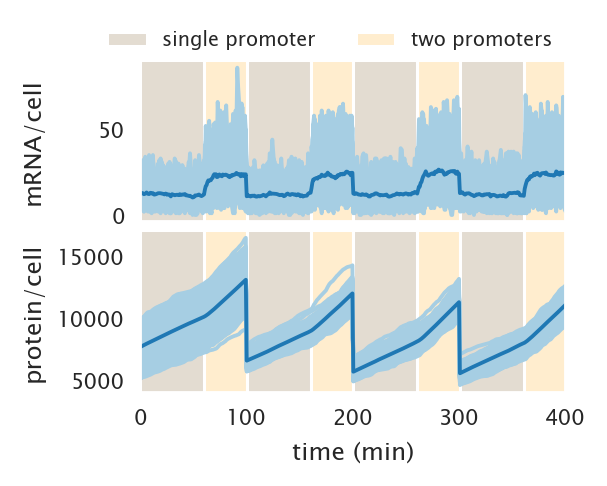

In [294]:
df_sim_prot = pd.read_csv(datadir + 'two_state_protein_gillespie_test4.csv',
                          index_col=0)

# Extract mRNA data
mRNA_names = [x for x in df_sim_prot.columns 
              if re.match(r"[m]\d", x)]
mRNA_data = df_sim_prot.loc[:, mRNA_names].values
# Compute mean mRNA
mRNA_mean = mRNA_data.mean(axis=1)

# Extract protein data
protein_names = [x for x in df_sim_prot.columns 
                 if re.match(r"[p]\d", x)]
protein_data = df_sim_prot.loc[:, protein_names].values
# Compute mean protein
protein_mean = protein_data.mean(axis=1)

# Initialize plot
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2), sharex=True)

# Define colors
colors = sns.color_palette('Paired', n_colors=2)

# Define time stepsize for plot
binstep = 10
# Define every how many trajectories to plot
simnum = 1


# Plot mRNA trajectories
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean mRNA
ax[0].plot(df_sim_prot['time'][0::binstep] / 60,
           mRNA_mean[0::binstep],
           color=colors[1])

# Plot protein trajectories
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_data[0::binstep, 0::simnum],
           color=colors[0])
# Plot mean protein
ax[1].plot(df_sim_prot['time'][0::binstep] / 60,
           protein_mean[0::binstep],
           color=colors[1])

# Group data frame by cell cycle
df_group = df_sim_prot.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_sim_prot['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
               data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)


# Set limits
ax[0].set_xlim(df_sim_prot['time'].min() / 60, 
            df_sim_prot['time'].max() / 60)
# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel('mRNA/cell')
ax[1].set_ylabel('protein/cell')

# Set legend for both plots
ax[0].legend(loc='upper left', ncol=2, frameon=False,
             bbox_to_anchor=(-0.12, 0, 0, 1.3), fontsize=6.5)

# Align y axis labels
fig.align_ylabels()

plt.subplots_adjust(hspace=0.05)

plt.savefig(figdir + 'two_state_mRNA_protein_gillespie_test4.pdf')